# <center> **CSCI-E82 Assignment 5 - NLP & Clustering**
###<center>Nitesh Kumar - Janice Pham</center>
</br>

# Set Up Notebook

## Install Packages

In [1]:
!pip install nltk transformers spacy sentence-transformers wordcloud --quiet

     |████████████████████████████████| 5.5 MB 4.4 MB/s 
     |████████████████████████████████| 85 kB 2.3 MB/s 
     |████████████████████████████████| 7.6 MB 44.6 MB/s 
     |████████████████████████████████| 182 kB 56.7 MB/s 
     |████████████████████████████████| 1.3 MB 69.9 MB/s 


## Import Packages

In [2]:
# System
import time
import os
import requests
import datetime
from collections import Counter
import random as rn
import re
import string

# Libraries
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from wordcloud import WordCloud
from numpy import nan
%matplotlib inline


# SKLearn
from sklearn.metrics import confusion_matrix, mean_squared_error, adjusted_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.neighbors import NearestNeighbors, NearestCentroid
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering


# Scipy
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage


# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers


# NLP
import nltk
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
from transformers import BertTokenizer, TFBertForSequenceClassification, AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.feature_extraction.text import CountVectorizer
import spacy


## Set Up Working Directory & Access to Data

In [3]:
#################################################
### SET UP WORKING DIRECTORY & ACCESS TO DATA ###
#################################################

# Get data from github to bypasss Google Drive Authentication
!git clone https://github.com/mlp2501/capstone_hes22.git

# Change working directory to data folder
os.chdir('capstone_hes22/cs82/HW5')


Cloning into 'capstone_hes22'...
remote: Enumerating objects: 43357, done.
remote: Counting objects: 100% (594/594), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 43357 (delta 254), reused 578 (delta 249), pack-reused 42763
Receiving objects: 100% (43357/43357), 233.79 MiB | 22.88 MiB/s, done.
Resolving deltas: 100% (503/503), done.
Checking out files: 100% (42948/42948), done.


# Data Pre-Processing

## EDA

In [11]:
###------ Reading data files ------###
asthma_dat = pd.read_table('asthma_exclusion.txt')
prostate_dat = pd.read_table('Prostate Cancer.txt')

# Print result
print(f'Asthma Data Shape: {asthma_dat.shape} \n' + '='*80)
display(asthma_dat.head(3))
print(f'\nProstate Data Shape: {prostate_dat.shape} \n' + '='*80)
display(prostate_dat.head(3))

Asthma Data Shape: (2435, 8) 


NCT#    phase condition                       sponsor start_date  \
0  NCT01650441  Phase 2    Asthma  University Hospital, Antwerp  10-Feb-15   
1  NCT02162784  Phase 2    Asthma          Intech Biopharm Ltd.  10-Feb-15   
2  NCT02740543  Phase 2    Asthma            NYU Langone Health  10-Feb-15   

  mesh_list                                          criterion  Ground_Truth  
0    Asthma  Inability to carry out pulmonary function testing           0.0  
1    Asthma  Inability to carry out pulmonary function test...           0.0  
2    Asthma  Inability to perform lung function or other ma...           0.0


Prostate Data Shape: (14319, 7) 


NCT# phase        condition                       sponsor  \
0  NCT00003045   NaN  Prostate Cancer  Dana-Farber Cancer Institute   
1  NCT00003045   NaN  Prostate Cancer  Dana-Farber Cancer Institute   
2  NCT00003045   NaN  Prostate Cancer  Dana-Farber Cancer Institute   

  start_date                         mesh_list  \
0  10-Feb-15  Prostatic Neoplasms;Hyperthermia   
1  10-Feb-15  Prostatic Neoplasms;Hyperthermia   
2  10-Feb-15  Prostatic Neoplasms;Hyperthermia   

                                           criterion  
0  Prior history of malignancy (except for non-me...  
1                             Prior systemic therapy  
2                              No prior chemotherapy

In [ ]:
###------ Asthma Data: Ground_truth data exploration------###
print('='*80 + '\nAsthma Data Ground Truth Clusters:\n' + '='*80)
asthma_dat['Ground_Truth'].unique()


Asthma Data Ground Truth Clusters:


array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29., 290.,  30.,  31.,
        32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,
        87.,  88.,  89., 101., 102., 103., 104., 889.,  nan])

There is cluster **889** here that seems to be a mistake as the cluster number is completely different from others, we doubt it should have been **89** instead of **889** so we will do some checks to compare cluster **89** criterions and those of cluster **889**.

In [ ]:
print('='*80 + '\nAsthma Data - Cluster 889\n' + '='*80)
asthma_dat[asthma_dat['Ground_Truth']==889]

Asthma Data - Cluster 889


NCT#    phase condition                     sponsor start_date  \
2427  NCT00868023  Phase 2    Asthma  Chiesi Farmaceutici S.p.A.  10-Feb-15   

     mesh_list                               criterion  Ground_Truth  
2427    Asthma  Diagnosis of restrictive lung disease.         889.0

In [ ]:
print('='*80 + '\nAsthma Data - Cluster 89\n' + '='*80)
asthma_dat[asthma_dat['Ground_Truth']==89]

Asthma Data - Cluster 89


NCT#    phase condition                     sponsor start_date  \
2406  NCT01349257  Phase 2    Asthma  Chiesi Farmaceutici S.p.A.  10-Feb-15   
2407  NCT01651650  Phase 2    Asthma  Chiesi Farmaceutici S.p.A.  10-Feb-15   
2408  NCT02148120  Phase 2    Asthma  Chiesi Farmaceutici S.p.A.  10-Feb-15   
2409  NCT01584492  Phase 2    Asthma  Chiesi Farmaceutici S.p.A.  10-Feb-15   

     mesh_list                               criterion  Ground_Truth  
2406       NaN   Diagnosis of restrictive lung disease          89.0  
2407    Asthma   Diagnosis of restrictive lung disease          89.0  
2408       NaN  Diagnosis of restrictive lung disease;          89.0  
2409    Asthma  Diagnosis of restrictive lung disease.          89.0

Based on the above tables, we confirm that cluster **889** is a mistake and we will cluster that sentences to cluster **89** instead.

In [ ]:
###------ Replace Instance 2427 with Cluster 89 from 889 ------###
asthma_dat.iloc[2427] = asthma_dat.iloc[2427].replace(889, 89)
asthma_dat.iloc[2427]

NCT#                                       NCT00868023
phase                                          Phase 2
condition                                       Asthma
sponsor                     Chiesi Farmaceutici S.p.A.
start_date                                   10-Feb-15
mesh_list                                       Asthma
criterion       Diagnosis of restrictive lung disease.
Ground_Truth                                      89.0
Name: 2427, dtype: object

There is also cluster **290** next to cluster **29** and chances are that this is also a mistake as well. We check both of these clusters to see if their criterions are similar.

In [ ]:
print('='*80 + '\nAsthma Data - Cluster 29\n' + '='*80)
display(asthma_dat[asthma_dat['Ground_Truth']==29].iloc[:3])
print('='*80 + '\nAsthma Data - Cluster 290\n' + '='*80)
display(asthma_dat[asthma_dat['Ground_Truth']==290])

Asthma Data - Cluster 29


NCT#    phase condition                     sponsor start_date  \
1289  NCT01370031  Phase 2    Asthma  Chiesi Farmaceutici S.p.A.  10-Feb-15   
1290  NCT00640016  Phase 2    Asthma               MedImmune LLC  10-Feb-15   
1291  NCT02720081  Phase 2    Asthma   Merck Sharp & Dohme Corp.  10-Feb-15   

     mesh_list                                          criterion  \
1289    Asthma  Blood donation (450 mL or more)or significant ...   
1290    Asthma  Blood donation (more than 550 mL) in the previ...   
1291    Asthma   Blood donation within 2 weeks of screening visit   

      Ground_Truth  
1289          29.0  
1290          29.0  
1291          29.0

Asthma Data - Cluster 290


NCT#    phase             condition                     sponsor  \
1318  NCT00968669  Phase 2                Asthma               MedImmune LLC   
1319  NCT00768079  Phase 2                Asthma               MedImmune LLC   
1320  NCT00873860  Phase 2                Asthma               MedImmune LLC   
1321  NCT01238861  Phase 2                Asthma               MedImmune LLC   
1322  NCT03010436  Phase 2                Asthma      National Jewish Health   
1323  NCT04617171  Phase 2  Asthma Attack;Asthma  Singapore General Hospital   

     start_date            mesh_list  \
1318  10-Feb-15               Asthma   
1319  10-Feb-15               Asthma   
1320  10-Feb-15               Asthma   
1321  10-Feb-15               Asthma   
1322  10-Feb-15  Systemic Vasculitis   
1323  10-Feb-15               Asthma   

                                              criterion  Ground_Truth  
1318  Receipt of immunoglobulin or blood products wi...         290.0  
1319  Receipt of immunoglobulin or blood products wi...         290.0  
1320  Receipt of immunoglobulin or blood products wi...         290.0  
1321  Receipt of immunoglobulin or blood products wi...         290.0  
1322  Receipt of immunoglobulin or blood products wi...         290.0  
1323  Subjects who receive immunoglobulin or blood p...         290.0

These 2 clusters share similar criterions and there are only 6 instances in cluster **290**. We will re-classfiy these 6 instances to cluster **29** instead.

In [ ]:
###------ Replace Instances with Cluster #290 to Cluster #29 ------###
for i in asthma_dat[asthma_dat['Ground_Truth']==290].index:
  asthma_dat.iloc[i] = asthma_dat.iloc[i].replace(290, 29)

# Checking nan entries
asthma_dat.iloc[1318:1324]

NCT#    phase             condition                     sponsor  \
1318  NCT00968669  Phase 2                Asthma               MedImmune LLC   
1319  NCT00768079  Phase 2                Asthma               MedImmune LLC   
1320  NCT00873860  Phase 2                Asthma               MedImmune LLC   
1321  NCT01238861  Phase 2                Asthma               MedImmune LLC   
1322  NCT03010436  Phase 2                Asthma      National Jewish Health   
1323  NCT04617171  Phase 2  Asthma Attack;Asthma  Singapore General Hospital   

     start_date            mesh_list  \
1318  10-Feb-15               Asthma   
1319  10-Feb-15               Asthma   
1320  10-Feb-15               Asthma   
1321  10-Feb-15               Asthma   
1322  10-Feb-15  Systemic Vasculitis   
1323  10-Feb-15               Asthma   

                                              criterion  Ground_Truth  
1318  Receipt of immunoglobulin or blood products wi...          29.0  
1319  Receipt of immunoglobulin or blood products wi...          29.0  
1320  Receipt of immunoglobulin or blood products wi...          29.0  
1321  Receipt of immunoglobulin or blood products wi...          29.0  
1322  Receipt of immunoglobulin or blood products wi...          29.0  
1323  Subjects who receive immunoglobulin or blood p...          29.0

We also see there is **nan** in the cluster list and we will check for these **nan** values as well.

In [ ]:
print('='*80 + '\nAsthma Data - Cluster nan\n' + '='*80)
asthma_dat[pd.isna(asthma_dat['Ground_Truth'])==True]


Asthma Data - Cluster nan


NCT#    phase condition  \
2428  NCT02712047  Phase 2    Asthma   
2429  NCT02720081  Phase 2    Asthma   
2430  NCT01402986  Phase 2    Asthma   
2431  NCT04643158  Phase 2    Asthma   
2432  NCT00812929  Phase 2    Asthma   
2433  NCT02153541  Phase 2    Asthma   
2434  NCT01743768  Phase 2    Asthma   

                                       sponsor start_date  \
2428                           GlaxoSmithKline  10-Feb-15   
2429                 Merck Sharp & Dohme Corp.  10-Feb-15   
2430                             MedImmune LLC  10-Feb-15   
2431                               AstraZeneca  10-Feb-15   
2432                           GlaxoSmithKline  10-Feb-15   
2433  Global United Pharmaceutical Corporation  10-Feb-15   
2434          Sterna Biologicals GmbH & Co. KG  10-Feb-15   

                          mesh_list  \
2428                         Asthma   
2429                         Asthma   
2430                         Asthma   
2431  Asthma;Respiratory Aspiration   
2432                         Asthma   
2433                         Asthma   
2434                         Asthma   

                                              criterion  Ground_Truth  
2428  Historical Allergy: History of drug or other a...           NaN  
2429  History of a psychiatric disorder within 3 mon...           NaN  
2430                                  History of cancer           NaN  
2431  History or clinical suspicion of any clinicall...           NaN  
2432  Known history of hypertension or is hypertensi...           NaN  
2433  Known or suspected sensitivity to the investig...           NaN  
2434  Presence of relevant pulmonary diseases or his...           NaN

It seems that there is no cluster assigned to these instances. Since there are only 8 instances with NaN, we will remove them from the dataset.

In [ ]:
###------ Drop NaN Cluster Instances ------###
print(f'Asthma Data Shape Before Dropping: {asthma_dat.shape}')
asthma_dat = asthma_dat.drop(asthma_dat[pd.isna(asthma_dat['Ground_Truth'])==True].index).reset_index(drop=True)
print(f'Asthma Data Shape After Dropping: {asthma_dat.shape}')

Asthma Data Shape Before Dropping: (2435, 8)
Asthma Data Shape After Dropping: (2428, 8)


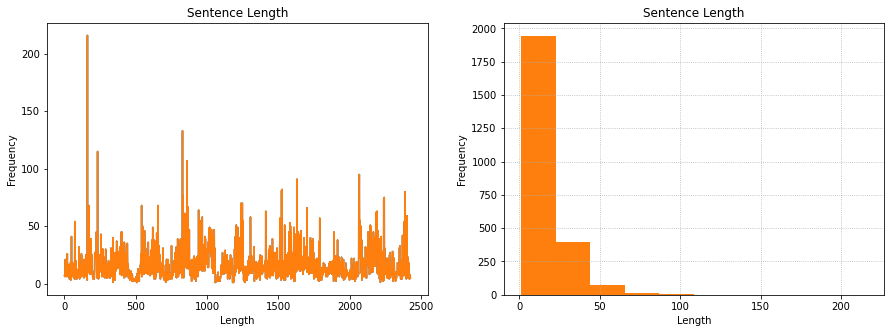

In [ ]:
###------ ASTHMA DATA: Count sentences' length and plot ------###
asthma_sentence_lens = [len(i) for i in asthma_dat['criterion'].str.split()]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in ax.flatten():
  ax[0].plot(asthma_sentence_lens)
  ax[1].hist(asthma_sentence_lens)
  ax[0].set_title('Sentence Length')
  ax[1].set_title('Sentence Length')
  ax[0].set_xlabel('Length')
  ax[1].set_xlabel('Length')
  ax[0].set_ylabel('Frequency')
  ax[1].set_ylabel('Frequency')
  plt.grid(ls=':')
  

According to the above plots, most sentences have less than 50 words with the majority of them are actually less than 25 words. There are few sentences with over 200 words and over 100 words. The sentence with over 200 words is an outlier and removed from the dataset.

In [ ]:
###------ ASTHMA DATA: Remove outlier ------###
asthma_outlier_idx = np.argmax(asthma_sentence_lens)
print(f'Data length before removing outlier: {len(asthma_sentence_lens)}')
del(asthma_sentence_lens[asthma_outlier_idx])
print(f'Data length after removing outlier: {len(asthma_sentence_lens)}')


Data length before removing outlier: 2428
Data length after removing outlier: 2427


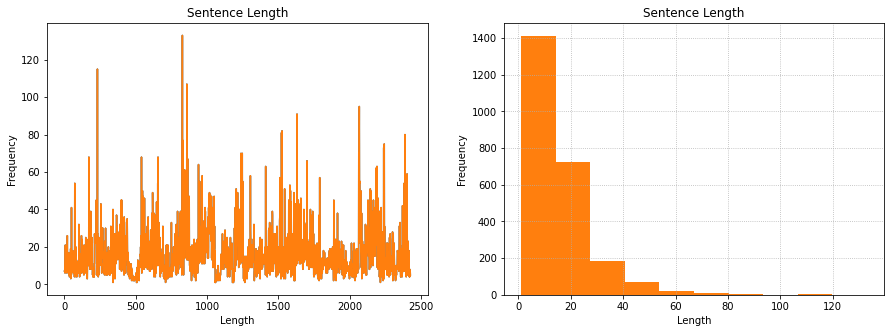

In [ ]:
###------ ASTHMA DATA: Re-plot the dataset after removing outlier ------###

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in ax.flatten():
  ax[0].plot(asthma_sentence_lens)
  ax[1].hist(asthma_sentence_lens)
  ax[0].set_title('Sentence Length')
  ax[1].set_title('Sentence Length')
  ax[0].set_xlabel('Length')
  ax[1].set_xlabel('Length')
  ax[0].set_ylabel('Frequency')
  ax[1].set_ylabel('Frequency')
  plt.grid(ls=':')

In [ ]:
###------ ASTHMA DATA: Remove outlier from original dataset ------###
asthma_dat = asthma_dat.drop(asthma_outlier_idx).reset_index(drop=True)
print(f'Data shape: {asthma_dat.shape}')

Data shape: (2427, 8)


In [ ]:
###------ Write Modified Asthma Dataset to CSV ------###
asthma_dat.to_csv('modified_asthma.csv')

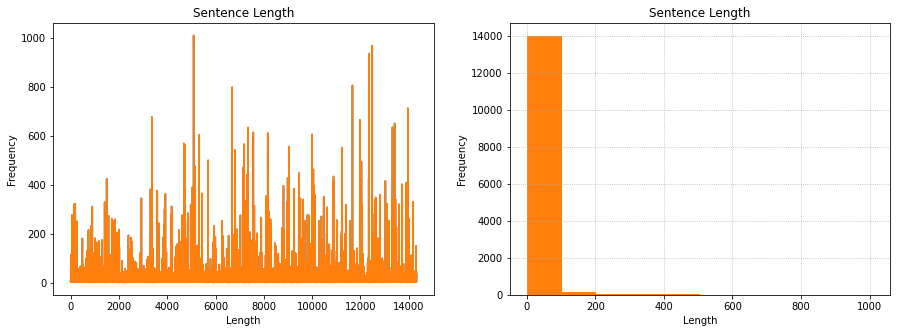

In [12]:
###------ PROSTATE DATA: Count sentences' length and plot ------###
prostate_sentence_lens = [len(i) for i in prostate_dat['criterion'].str.split()]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in ax.flatten():
  ax[0].plot(prostate_sentence_lens)
  ax[1].hist(prostate_sentence_lens)
  ax[0].set_title('Sentence Length')
  ax[1].set_title('Sentence Length')
  ax[0].set_xlabel('Length')
  ax[1].set_xlabel('Length')
  ax[0].set_ylabel('Frequency')
  ax[1].set_ylabel('Frequency')
  plt.grid(ls=':')
  

In [13]:
###------ PROSTATE DATA: Remove outlier ------###
prostate_top10_len = sorted(prostate_sentence_lens, reverse=True)[:10]
print(f'Top 10 longest sentence length: {prostate_top10_len}')
prostate_outlier_idx = [prostate_sentence_lens.index(x) for x in prostate_top10_len][:5]
print(f'Data length before removing outlier: {len(prostate_sentence_lens)}')
prostate_sentence_lens = [i for i in prostate_sentence_lens if i not in prostate_top10_len[:5]]
print(f'Data length after removing outlier: {len(prostate_sentence_lens)}')


Top 10 longest sentence length: [1010, 968, 936, 806, 799, 713, 677, 665, 651, 635]
Data length before removing outlier: 14319
Data length after removing outlier: 14314


There are a few very long sentences with over 800 words. We will remove the top 5 longest sentences from Prostate dataset.

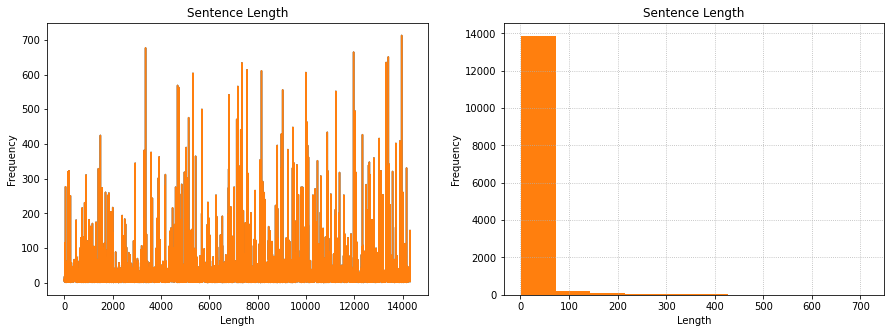

In [14]:
###------ PROSTATE DATA: Re-plot the dataset after removing outlier ------###

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in ax.flatten():
  ax[0].plot(prostate_sentence_lens)
  ax[1].hist(prostate_sentence_lens)
  ax[0].set_title('Sentence Length')
  ax[1].set_title('Sentence Length')
  ax[0].set_xlabel('Length')
  ax[1].set_xlabel('Length')
  ax[0].set_ylabel('Frequency')
  ax[1].set_ylabel('Frequency')
  plt.grid(ls=':')

In [15]:
###------ PROSTATE DATA: Remove outlier from original dataset ------###
prostate_dat = prostate_dat.drop(prostate_outlier_idx).reset_index(drop=True)
print(f'Data shape: {prostate_dat.shape}')

Data shape: (14314, 7)


## Text Pre-Processing

In this section, we first process data by converting sentences to lowercase and removing punctuations. Next, we will use 2 pre-trained BERT models (SciBert and BioBert) for sentence embeddings.

Our modeling section later will rely on these 2 sets of text embeddings, and we run the clustering algorithms on each of these text embeddings. In other words, there will be 2 models for each algorithm (i.e., KMeans-Scibert & KMeans-BioBert).

In [ ]:
                                ######################
                                ### ASTHMA DATASET ###
                                ######################

###------ Convert to lowercase & Remove punctuations  ------###
print('='*100 + '\nLOWERCASE & REMOVING PUNCTUATIONS' + '\nBefore:\n')
display(asthma_dat['criterion'].head(3))
asthma_dat['criterion'] = asthma_dat['criterion'].apply(lambda x: str(x).lower())
asthma_dat['criterion'] = asthma_dat['criterion'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
print(f'\n\nAfter:')
display(asthma_dat['criterion'].head(3))
print('\n' + '='*100)



###------ Remove StopWords using Spacy package ------###
# Loading English language model
nlp_spacy = spacy.load('en_core_web_sm')
all_stopwords = nlp_spacy.Defaults.stop_words
asthma_dat['no_sw_criterion'] = asthma_dat['criterion'].apply(lambda x: \
                                  ' '.join([token.lemma_ for token in list(nlp_spacy(x)) if (token.is_stop==False)]))


# Print criterion example
print('REMOVING STOPWORDS\n')
display(asthma_dat['no_sw_criterion'].iloc[:5])


LOWERCASE & REMOVING PUNCTUATIONS
Before:



0    Inability to carry out pulmonary function testing
1    Inability to carry out pulmonary function test...
2    Inability to perform lung function or other ma...
Name: criterion, dtype: object



After:


0    inability to carry out pulmonary function testing
1    inability to carry out pulmonary function testing
2    inability to perform lung function or other ma...
Name: criterion, dtype: object


REMOVING STOPWORDS



0           inability carry pulmonary function testing
1           inability carry pulmonary function testing
2             inability perform lung function maneuver
3    patient unable perform pulmonary function testing
4          poor performance pulmonary function testing
Name: no_sw_criterion, dtype: object

In [16]:
                                ########################
                                ### PROSTATE DATASET ###
                                ########################

###------ Convert to lowercase & Remove punctuations  ------###
print('='*100 + '\nLOWERCASE & REMOVING PUNCTUATIONS' + '\nBefore:\n')
display(prostate_dat['criterion'].head(3))
prostate_dat['criterion'] = prostate_dat['criterion'].apply(lambda x: str(x).lower())
prostate_dat['criterion'] = prostate_dat['criterion'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
print(f'\n\nAfter:')
display(prostate_dat['criterion'].head(3))
print('\n' + '='*100)



###------ Remove StopWords using Spacy package ------###
# Loading English language model
nlp_spacy = spacy.load('en_core_web_sm')
all_stopwords = nlp_spacy.Defaults.stop_words
prostate_dat['no_sw_criterion'] = prostate_dat['criterion'].apply(lambda x: \
                                  ' '.join([token.lemma_ for token in list(nlp_spacy(x)) if (token.is_stop==False)]))


# Print criterion example
print('REMOVING STOPWORDS\n')
display(prostate_dat['no_sw_criterion'].iloc[:5])


LOWERCASE & REMOVING PUNCTUATIONS
Before:



0    Prior history of malignancy (except for non-me...
1                               Prior systemic therapy
2                                No prior chemotherapy
Name: criterion, dtype: object



After:


0    prior history of malignancy except for nonmela...
1                               prior systemic therapy
2                                no prior chemotherapy
Name: criterion, dtype: object


REMOVING STOPWORDS



0    prior history malignancy nonmelanoma skin cancer
1                              prior systemic therapy
2                                  prior chemotherapy
3           prior hormonal therapy recommend protocol
4                           prior pelvic radiotherapy
Name: no_sw_criterion, dtype: object

In [ ]:
                        ######################################
                        ### ASTHMA DATASET: TEXT EMBEDDING ###
                        ######################################

###------ SCIBERT ------###
model_scibert = 'allenai/scibert_scivocab_uncased'
scibert_transformer_model = SentenceTransformer(model_scibert)

###------ BIOBERT ------###
model_biobert = 'dmis-lab/biobert-base-cased-v1.2'
biobert_transformer_model = SentenceTransformer(model_biobert)

###------ Embedding all sentences ------###
asthma_embeddings_scibert = scibert_transformer_model.encode(asthma_dat['no_sw_criterion'], convert_to_tensor=True)
asthma_embeddings_biobert = biobert_transformer_model.encode(asthma_dat['no_sw_criterion'], convert_to_tensor=True)


Downloading:   0%|          | 0.00/437 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/dmis-lab_biobert-base-cased-v1.2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
                        ########################################
                        ### PROSTATE DATASET: TEXT EMBEDDING ###
                        ########################################

###------ SCIBERT ------###
prostate_scibert_transformer_model = SentenceTransformer(model_scibert)

###------ BIOBERT ------###
prostate_biobert_transformer_model = SentenceTransformer(model_biobert)

###------ Embedding all sentences ------###
prostate_embeddings_scibert = prostate_scibert_transformer_model.encode(prostate_dat['no_sw_criterion'], convert_to_tensor=True)
prostate_embeddings_biobert = prostate_biobert_transformer_model.encode(prostate_dat['no_sw_criterion'], convert_to_tensor=True)


Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /root/.cache/torch/sentence

## Wordcloud Visualization

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


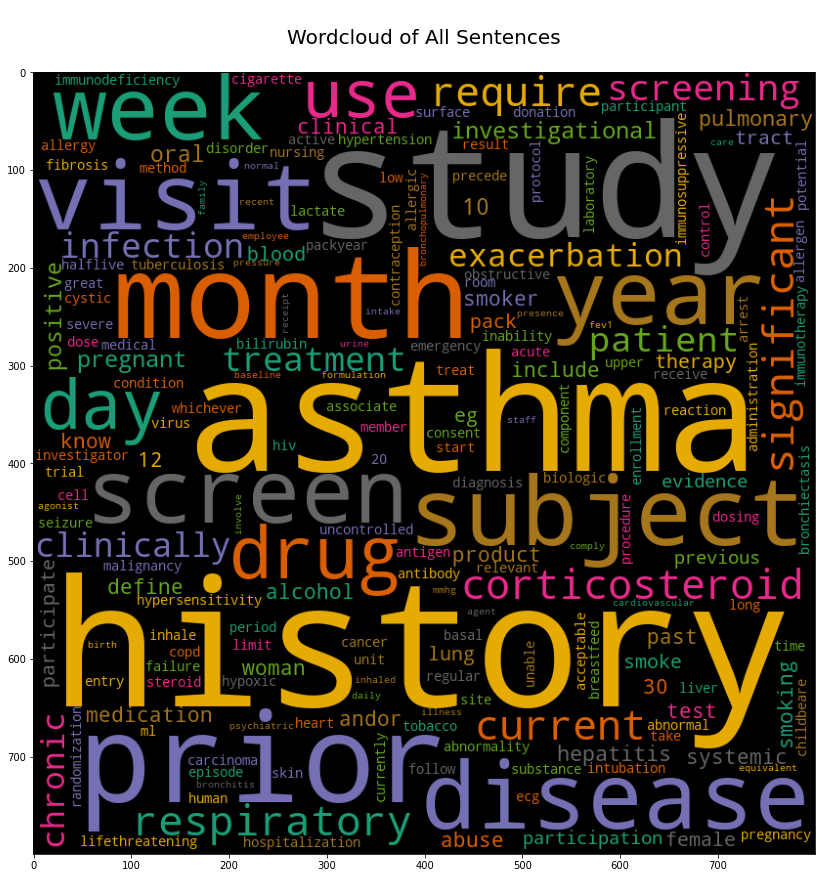

In [ ]:
                                ######################
                                ### ASTHMA DATASET ###
                                ######################

###------ Wordcloud ------###

# Initialize CountVectorizer to convert text to vector
asthma_count_vectorizer = CountVectorizer(analyzer='word')

# Aggregate all sentences to 1 group and convert to data frame
vectorized_asthma = asthma_count_vectorizer.fit_transform(asthma_dat[['no_sw_criterion']].apply('.'.join))
vectorized_asthma = pd.DataFrame(vectorized_asthma.toarray(), columns = asthma_count_vectorizer.get_feature_names())

# Create wordcloud from all sentences and plot wordcloud
asthma_wordcloud = WordCloud(width = 800, height = 800, colormap="Dark2",
                min_font_size = 10).generate_from_frequencies(vectorized_asthma.iloc[0])

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(asthma_wordcloud)
ax.set_title('\nWordcloud of All Sentences\n', fontsize=20)
plt.tight_layout(pad = 0)
plt.show()



The Wordcloud representation suggests a few important words that frequently appear across all sentences. While this is yet to be confirmed, we have a reason to believe the clustering methods might group sentences that contain these important words together while less popular sentences (containing less popular words) would be grouped into same clusters (or may be itself a separate cluster).

# Modeling

### Utilities Functions

In [ ]:
###------ Silhuoette Plot ------###

# Taken from the SciKit Learn website examples
# Plots the solhouette scores to check the selection of clusters
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

### Modify plot from above source
def make_silhouette(X_in, cluster_range):
    range_n_clusters = cluster_range
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 10)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_in) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X_in)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_in, cluster_labels, metric='cosine')
        print("\nFor n_clusters =", n_clusters,
              "the average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_in, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        #ax1.yaxis.set_ticks_position('none')
        #ax1.xaxis.set_ticks_position('none')
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.xaxis.grid(True)
        ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Draw white circles at cluster centers
        centers = clusterer.cluster_centers_

        
        # 2nd Plot showing the actual clusters formed
        # colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        
        # ax2.scatter(X_in[:, 1], X_in[:, 0], marker='.', s=100, lw=0, alpha=0.7, c=colors)
        # ax2.set_title("The visualization of the clustered data.")
        # ax2.set_xlabel('X_0')
        # ax2.set_ylabel('X_1')
        # ax2.grid(False)

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X_in[:, 0], X_in[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        #remove_border()
        plt.show()
        


In [ ]:
###------ Silhuoette Plot ------###

# Taken from the SciKit Learn website examples
# Plots the solhouette scores to check the selection of clusters
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

### MODIFY TO ALLOW FOR DIFFERENT CLUSTERING METHODS
def custom_silhouette(X_in, cluster_range, hc='N'):
    range_n_clusters = cluster_range
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 10)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_in) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if hc == 'N':
          clusterer = KMeans(n_clusters=n_clusters, random_state=10)
          cluster_labels = clusterer.fit_predict(X_in)
        elif hc == 'Y':
          clusterer = AgglomerativeClustering(n_clusters=n_clusters, \
                                              affinity='euclidean', \
                                              linkage='ward', compute_distances=True)
          cluster_labels = clusterer.fit_predict(X_in)
        else:
          print('Please specify HC')

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_in, cluster_labels, metric='cosine')
        print("\nFor n_clusters =", n_clusters,
              "the average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_in, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        #ax1.yaxis.set_ticks_position('none')
        #ax1.xaxis.set_ticks_position('none')
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.xaxis.grid(True)
        ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Draw white circles at cluster centers
        if hc == 'N':
          centers = clusterer.cluster_centers_
        elif hc == 'Y':
          nearest_centroid_model = NearestCentroid()
          nearest_centroid_model.fit(X_in, cluster_labels)
          centers = nearest_centroid_model.centroids_
        else:
          print('Please specify HC')

        
        # 2nd Plot showing the actual clusters formed
        # colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        
        # ax2.scatter(X_in[:, 1], X_in[:, 0], marker='.', s=100, lw=0, alpha=0.7, c=colors)
        # ax2.set_title("The visualization of the clustered data.")
        # ax2.set_xlabel('X_0')
        # ax2.set_ylabel('X_1')
        # ax2.grid(False)

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X_in[:, 0], X_in[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        #centers = clusterer.cluster_centers_
        if hc == 'N':
          centers = clusterer.cluster_centers_
        elif hc == 'Y':
          nearest_centroid_model = NearestCentroid()
          nearest_centroid_model.fit(X_in, cluster_labels)
          centers = nearest_centroid_model.centroids_
        else:
          print('Please specify HC')

        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        #remove_border()
        plt.show()
        


## K-Means Clustering

In this section, we will explore K-Means clustering based on 2 sets of text embeddings (SCIBERT and BIOBERT). We first run K-Means model across different number of clusters and evaluate elbow plot and Silhouette plot to select the optimal K.

### SCIBERT

#### Cluster Number Search

In [ ]:
                                  ###################################
                                  ### CLUSTERING BASED ON SCIBERT ###
                                  ###################################

###------ Looping through various K values ------###

### Dict of all models
asthma_km_skl_models_scibert = {}
for i in range(5,250,5):
    km_ = KMeans(n_clusters=i, init='k-means++', n_init=42, random_state=82).fit(asthma_embeddings_scibert)
    asthma_km_skl_models_scibert[i] = km_


### Dicts of all stats
asthma_km_skl_inertia_scibert = {}
asthma_km_skl_preds_scibert = {}
asthma_km_skl_sih_scores_scibert = {}
for k, v in asthma_km_skl_models_scibert.items():
    asthma_km_skl_inertia_scibert[k] = v.inertia_
    asthma_km_skl_preds_scibert[k] = v.predict(asthma_embeddings_scibert)
    asthma_km_skl_sih_scores_scibert[k] = silhouette_score(asthma_embeddings_scibert, v.labels_, metric='cosine')
                                                           
    
    

In [ ]:
###------ Function to plot elbow method and average Silhouette scores ------###
def elbow_silhouette_plot(range_idx, inertia, sih_scores):
  fig, ax = plt.subplots(2, 1, figsize=(15,15))

  for i in ax.flatten():
    ax[0].plot(range_idx, inertia, marker='o')
    ax[0].set_xlabel('Number of cluster $K$')
    ax[0].set_ylabel('Inertia')
    ax[0].set_title('Elbow Method for Selecting Optimal K Cluster')
    ax[0].grid(ls=':')

    ax[1].plot(range_idx, sih_scores, marker='o')
    ax[1].set_xlabel('Number of cluster $K$')
    ax[1].set_ylabel('Silhuoette Score')
    ax[1].set_title('Average Silhouette Score for Selecting Optimal K Cluster')
    ax[1].grid(ls=':')
  
  plt.show()

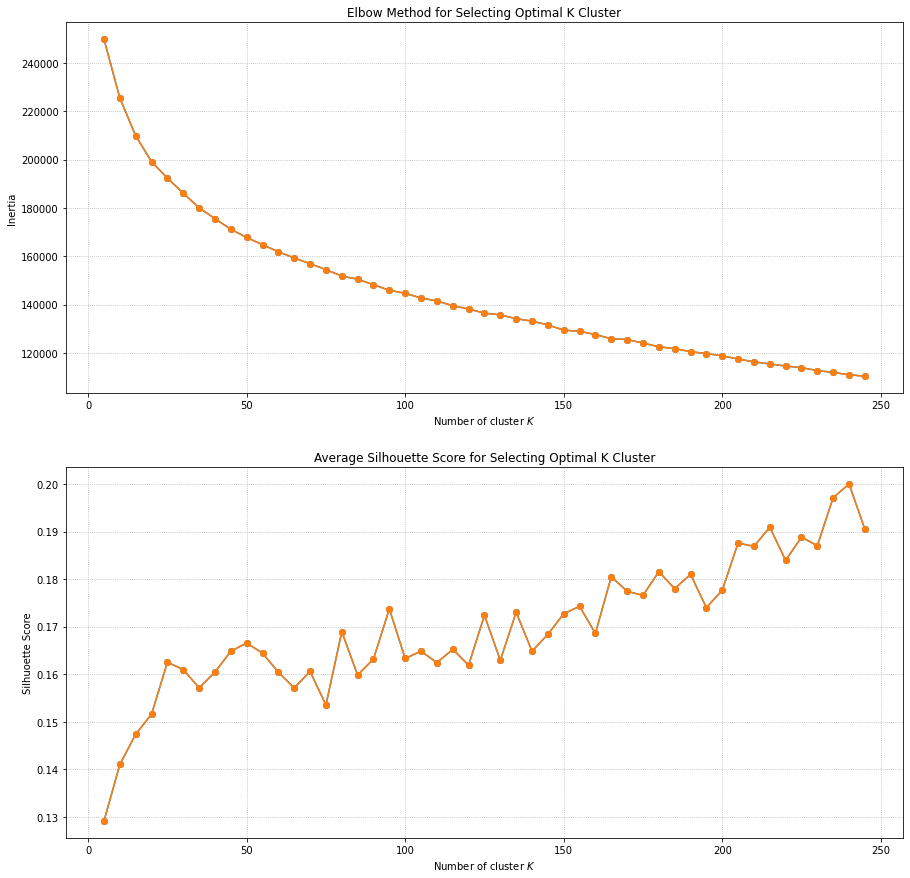

In [ ]:
###------ SCIBERT: Elbow Plot & Averageee Silhouette Score Plot ------###
elbow_silhouette_plot(range(5,250,5), \
                      list(asthma_km_skl_inertia_scibert.values()), \
                      list(asthma_km_skl_sih_scores_scibert.values()))

Based on the Elbow plot, the inertia (sum of squared distances of observations to their closest centroid) drops significantly at the beginning when K is small, and slowly decreases as K surpasses 75.

The average Silhuoette plot increases sharply up to K=25, then flutuates a lot and slowly increases as K goes up. The highest average Silhouette score is at K=240 for the first 250 Ks; however, K=95 seems to be a more reasonable number instead because between K=95 and K=240, the difference in average Silhouette scores is only about 0.02 but if we select higher K, we may risk overfitting. In addition, the elbow plot also suggests that between these 2 Ks, the inertia does not decrease sharply either. While average Silhuoette plot suggests we should select K corresponding to the highest score, we see here it is not appropriate to do so because the score keeps going up with Ks; therefore, we risk overfitting the data if we pick very high K.


#### Evaluation Metrics


For n_clusters = 20 the average silhouette_score is : 0.14044316


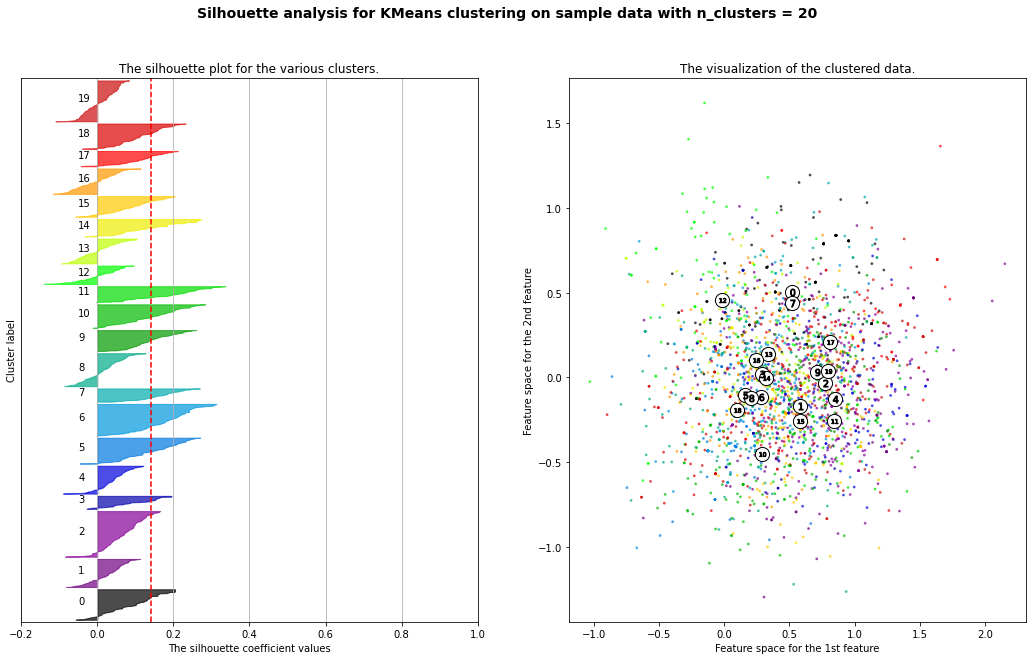


For n_clusters = 50 the average silhouette_score is : 0.15755561


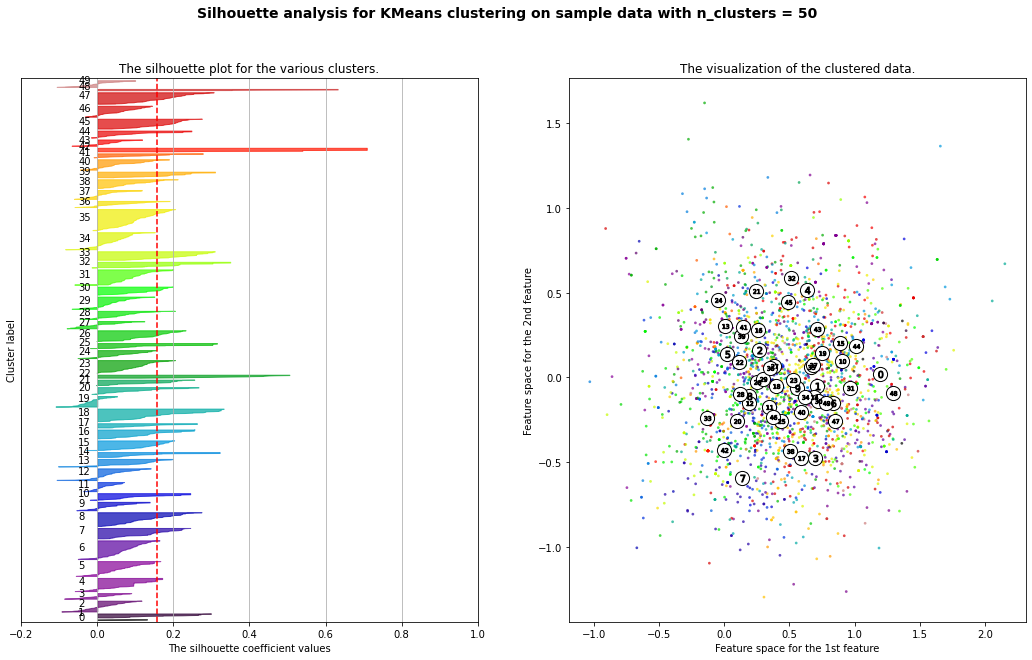


For n_clusters = 70 the average silhouette_score is : 0.15573752


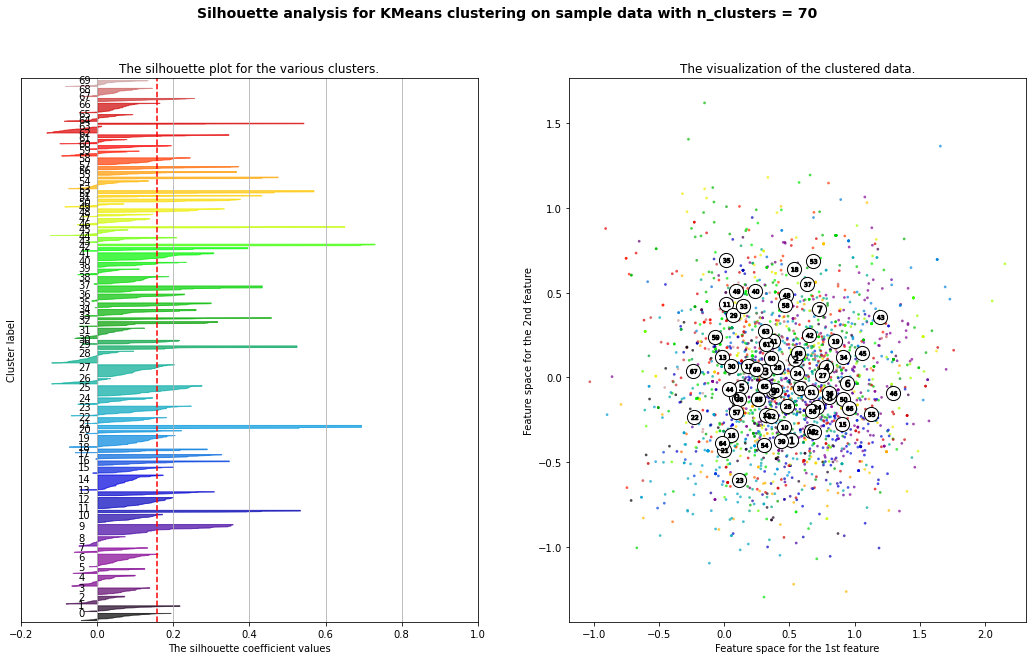


For n_clusters = 95 the average silhouette_score is : 0.16894528


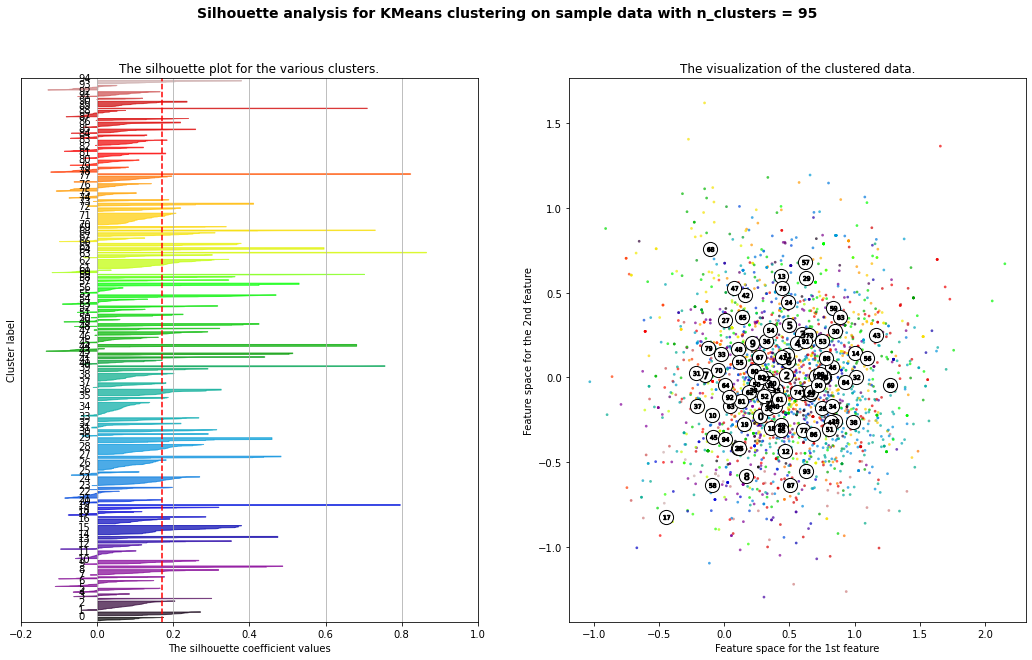

In [ ]:
###------ SCIBERT: Silhouette Plots ------###
make_silhouette(asthma_embeddings_scibert, [20, 50, 70, 95])

**Comments on Silhouette plots**
1. When K is small, the thickness of the Silhouette plots varies widely among clusters, i.e., some clusters have a lot more data points than others. As K increases, the thickness is more in line and similar with one another.

2. The Silhouette coefficients are higher as K increases - some of the Silhouette coefficients when K=95 actually surpass 0.8. This is because more data points are correctly classified to a cluster. While there remains some data points that are wrongly classified (negative scores), with the number of clusters = 95, this is not a surprise because there may be some clusters containing specific information or having special charateristics that a data point (a sentence in this case) does not fit in at all. However, comparing with smaller Ks in which negative clusters are thicker, the negative clusters in case of higher Ks are thinner, i.e. fewer points are wrongly classified.

3. Lastly, we do not want to pick a very high number of cluster (such as K=250) because we will risk overfitting the data.

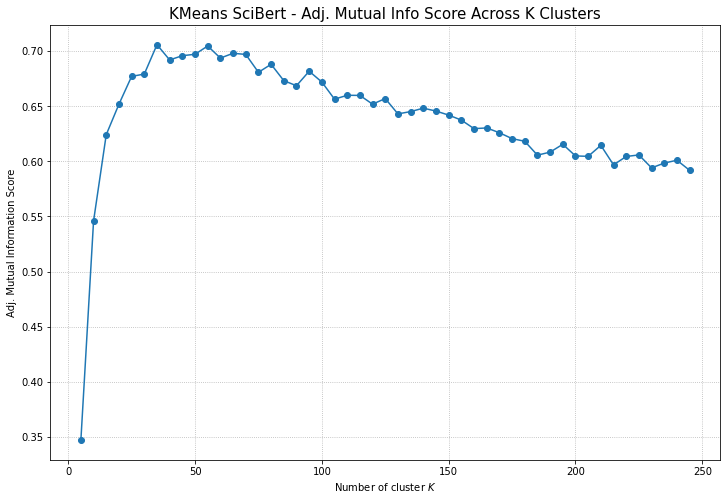

In [ ]:
###------ SCIBERT: Adjusted Mutual Information Score ------###
asthma_km_scibert_ami_dict = {}
for k, v in asthma_km_skl_models_scibert.items():
  asthma_km_scibert_ami_dict[k] = adjusted_mutual_info_score(asthma_dat['Ground_Truth'], v.labels_)

###------ SCIBERT: Adj. Mutual Info Score Plot ------###

fig, ax = plt.subplots(1, 1, figsize=(12,8))

ax.plot(list(asthma_km_scibert_ami_dict.keys()), list(asthma_km_scibert_ami_dict.values()), marker='o')
ax.set_xlabel('Number of cluster $K$')
ax.set_ylabel('Adj. Mutual Information Score')
ax.set_title('KMeans SciBert - Adj. Mutual Info Score Across K Clusters', fontsize=15)
ax.grid(ls=':')


The highest AMI score is at K=55 but the average Silhouette plot prefers a higher K of 95, and the difference in AMI scores between these 2 Ks is not really significant. Therefore we select K=95. We do not consider any K greater than 120 because the model overfits the data (as reflected by decreasing AMI scores). In addition, we do not want to select a smaller K either as it may risk underfitting.

In [ ]:
###------ SCIBERT: Create data frame of text, embeddings, and clusters ------###
asthma_clustering_df = pd.DataFrame({
    'criterion': asthma_dat['criterion'],
    'embeddings': [np.array(i) for i in asthma_embeddings_scibert],
    'scibert_kmeans': asthma_km_skl_models_scibert[95].labels_
})

asthma_clustering_df.head(10)

criterion  \
0  inability to carry out pulmonary function testing   
1  inability to carry out pulmonary function testing   
2  inability to perform lung function or other ma...   
3  patient unable to perform pulmonary function t...   
4    poor performance of pulmonary function testing    
5  acute illnesses or evidence of clinically sign...   
6  acute infection including viral infection with...   
7  culturedocumented or suspected bacterial or vi...   
8  culturedocumented or suspected bacterial or vi...   
9  currentactive upper respiratory infection if a...   

                                          embeddings  scibert_kmeans  
0  [-0.5822296, -0.50721264, 0.05819918, -0.18951...              83  
1  [-0.5822296, -0.50721264, 0.05819918, -0.18951...              83  
2  [-1.0294942, -0.025502924, -0.26240727, -0.377...              83  
3  [-0.004910692, -0.4367215, 0.22663999, -0.3332...              83  
4  [-0.62314427, -0.60829777, -0.20204248, 0.0822...              83  
5  [0.5319246, -1.2193029, -0.7470802, -0.2099371...              43  
6  [0.30988416, -0.5542537, -0.5900637, 0.5506909...              49  
7  [0.58317214, -0.07083454, -0.15572168, 0.36738...              43  
8  [0.58317214, -0.07083454, -0.15572168, 0.36738...              43  
9  [1.175599, 0.32576087, -1.1713809, 0.6721745, ...              15

Based on the above table, we see the first 5 sentences in cluster 83 appear to be similar to each other, suggesting they are correctly clustered to the same group. Reading these sentences, it seems the models is doing a good job at clustering these first 5 sentences.

Next, we will explore K-Means Clustering based on pre-trained BIOBERT model for text embedding.

In [ ]:
###------ SCIBERT: Adjusted Mutual Information Score ------###

km_scibert_asthma_ami = adjusted_mutual_info_score(asthma_dat['Ground_Truth'], asthma_km_skl_models_scibert[95].labels_)
print(f'Asthma SCIBERT - KMeans Model AMI Score: {round(100*km_scibert_asthma_ami, 3)}%')


Asthma SCIBERT - KMeans Model AMI Score: 68.178%


### BIOBERT

#### Cluster Number Search

In [ ]:
                                  ###################################
                                  ### CLUSTERING BASED ON BIOBERT ###
                                  ###################################

###------ Looping through various K values ------###

### Dict of all models
asthma_km_skl_models_biobert = {}
for i in range(5,250,5):
    km_ = KMeans(n_clusters=i, init='random', n_init=42, random_state=82).fit(asthma_embeddings_biobert)
    asthma_km_skl_models_biobert[i] = km_


### Dicts of all stats
asthma_km_skl_inertia_biobert = {}
asthma_km_skl_preds_biobert = {}
asthma_km_skl_sih_scores_biobert = {}
for k, v in asthma_km_skl_models_biobert.items():
    asthma_km_skl_inertia_biobert[k] = v.inertia_
    asthma_km_skl_preds_biobert[k] = v.predict(asthma_embeddings_biobert)
    asthma_km_skl_sih_scores_biobert[k] = silhouette_score(asthma_embeddings_biobert, v.labels_, metric='cosine')
                                                           

    
    

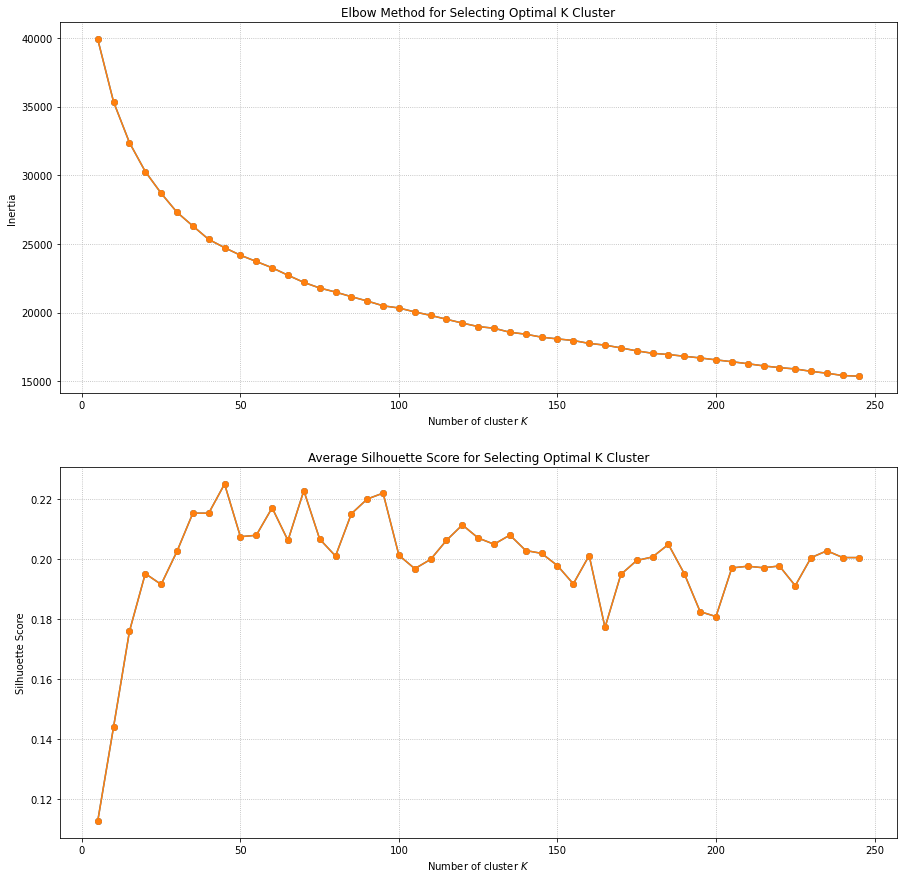

In [ ]:
###------ SCIBERT: Elbow Plot & Averageee Silhouette Score Plot ------###
elbow_silhouette_plot(range(5,250,5), \
                      list(asthma_km_skl_inertia_biobert.values()), \
                      list(asthma_km_skl_sih_scores_biobert.values()))

Similar to SCIBERT, the elbow plot suggests big drop for the first few Ks and then it fluctuates at about the same range slowly decreasing. The average Silhouette plot for BIOBERT model rises sharply for the first few Ks and peaks at K=45, then fluctuates within the sasme score range. In fact, BIOBERT seems to outperform SCIBERT: it only needs 45 clusters to surpass average Silhouette score of 0.22 while SCIBERT cannot even reach that score. Comparing between 2 models, SCIBERT tends to get better result if we keeps increasing K (overfit the data to get good result) while BIOBERT appears to be a more reliable model that does not rely on increasing number of clusters to perform well.


#### Evaluation Metrics


For n_clusters = 20 the average silhouette_score is : 0.1999794


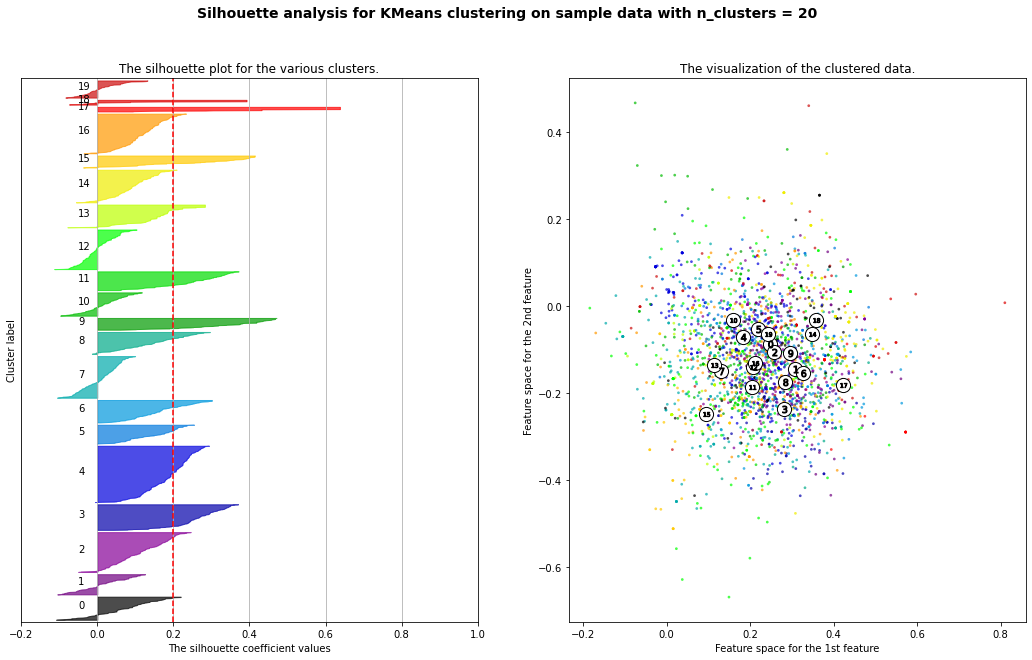


For n_clusters = 50 the average silhouette_score is : 0.20127603


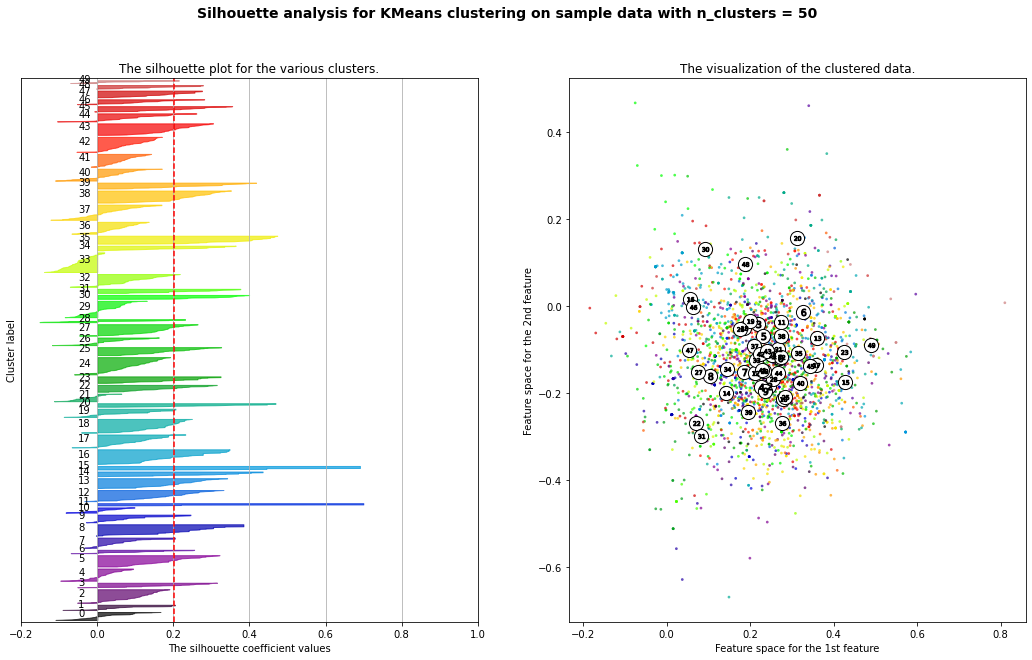


For n_clusters = 70 the average silhouette_score is : 0.23063868


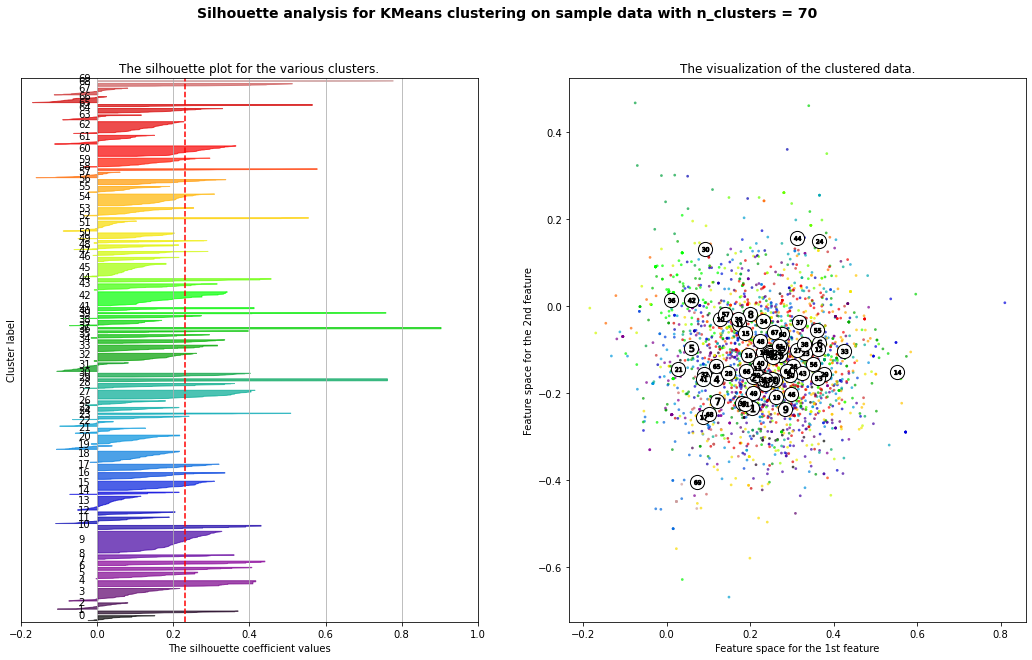


For n_clusters = 95 the average silhouette_score is : 0.22101155


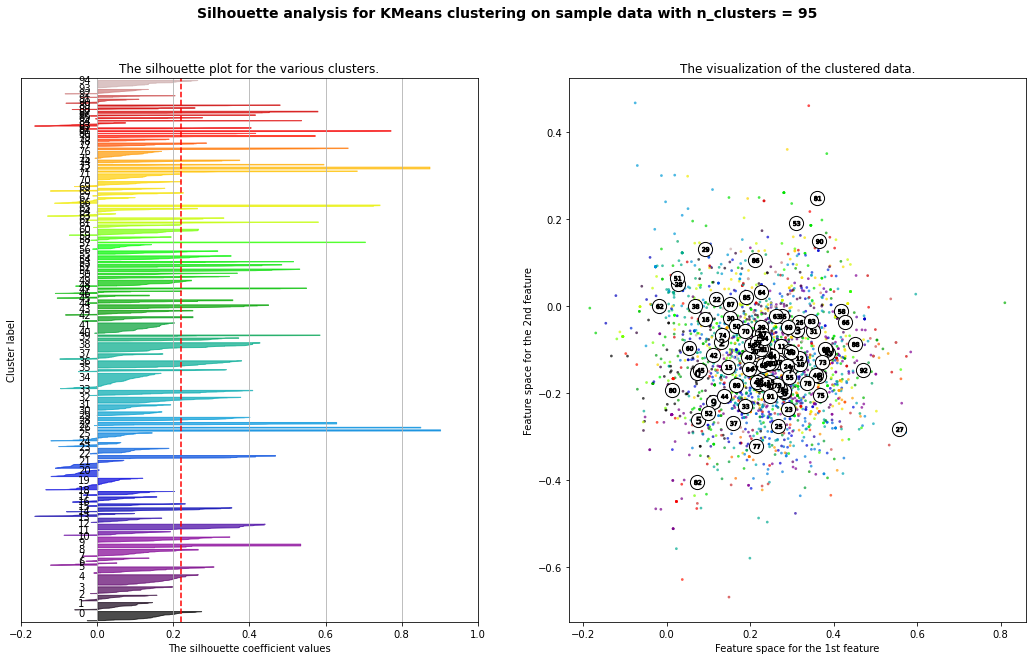

In [ ]:
###------ BIOBERT: Silhouette Plots ------###
make_silhouette(asthma_embeddings_biobert, [20, 50, 70, 95])

**Comments on Silhuoette plot:** the average Silhouette score for Biobert. K=95 is about 0.22, higher than that of Scibert (0.17). The plot patterns are almost similar to Scibert model.

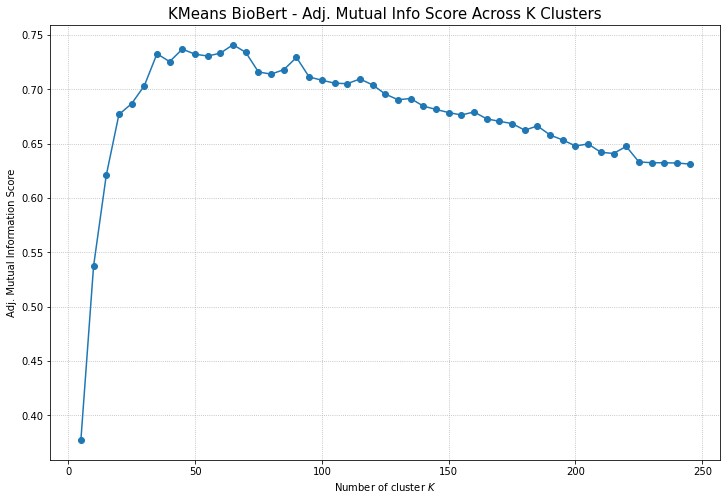

In [ ]:
###------ BIOBERT: Adjusted Mutual Information Score ------###
asthma_km_biobert_ami_dict = {}
for k, v in asthma_km_skl_models_biobert.items():
  asthma_km_biobert_ami_dict[k] = adjusted_mutual_info_score(asthma_dat['Ground_Truth'], v.labels_)

###------ BIOBERT: Adj. Mutual Info Score Plot ------###

fig, ax = plt.subplots(1, 1, figsize=(12,8))

ax.plot(list(asthma_km_biobert_ami_dict.keys()), list(asthma_km_biobert_ami_dict.values()), marker='o')
ax.set_xlabel('Number of cluster $K$')
ax.set_ylabel('Adj. Mutual Information Score')
ax.set_title('KMeans BioBert - Adj. Mutual Info Score Across K Clusters', fontsize=15)
ax.grid(ls=':')


There is not much difference in both AMI scores and average Silhouette scores between K=45 and K=95. We pick K=95 in this case because it is a more reasonable number when comparing with the size of the dataset (i.e., about 25 sentences per cluster).

**Model Comparison:**

In [ ]:
###------ Data frame of text, embeddings, and clusters ------###
asthma_clustering_df['biobert_kmeans'] = asthma_km_skl_models_biobert[95].labels_
asthma_clustering_df['ground_truth'] = asthma_dat['Ground_Truth']
asthma_clustering_df.head(10)

criterion  \
0  inability to carry out pulmonary function testing   
1  inability to carry out pulmonary function testing   
2  inability to perform lung function or other ma...   
3  patient unable to perform pulmonary function t...   
4    poor performance of pulmonary function testing    
5  acute illnesses or evidence of clinically sign...   
6  acute infection including viral infection with...   
7  culturedocumented or suspected bacterial or vi...   
8  culturedocumented or suspected bacterial or vi...   
9  currentactive upper respiratory infection if a...   

                                          embeddings  scibert_kmeans  \
0  [-0.5822296, -0.50721264, 0.05819918, -0.18951...              83   
1  [-0.5822296, -0.50721264, 0.05819918, -0.18951...              83   
2  [-1.0294942, -0.025502924, -0.26240727, -0.377...              83   
3  [-0.004910692, -0.4367215, 0.22663999, -0.3332...              83   
4  [-0.62314427, -0.60829777, -0.20204248, 0.0822...              83   
5  [0.5319246, -1.2193029, -0.7470802, -0.2099371...              43   
6  [0.30988416, -0.5542537, -0.5900637, 0.5506909...              49   
7  [0.58317214, -0.07083454, -0.15572168, 0.36738...              43   
8  [0.58317214, -0.07083454, -0.15572168, 0.36738...              43   
9  [1.175599, 0.32576087, -1.1713809, 0.6721745, ...              15   

   biobert_kmeans  ground_truth  
0              86           0.0  
1              86           0.0  
2              86           0.0  
3              86           0.0  
4              86           0.0  
5              61           1.0  
6              36           1.0  
7              61           1.0  
8              61           1.0  
9              81           1.0

According to the above table, similar to Scibert, Biobert K=100 model assigns the first 5 sentences to the same clusters. While the next 5 sentences have different cluster numbers by SciBert and Biobert, the assigment pattern is the same. It is slightly different from the ground truth result for these 5 sentences.

In [ ]:
###------ BIOBERT: Adjusted Mutual Information Score ------###

km_biobert_asthma_ami = adjusted_mutual_info_score(asthma_dat['Ground_Truth'], asthma_km_skl_models_biobert[95].labels_)
print(f'Asthma BIOBERT - KMeans Model AMI Score: {round(100*km_biobert_asthma_ami, 3)}%')


Asthma BIOBERT - KMeans Model AMI Score: 71.128%


## Mean-Shift Clustering

### SCIBERT

In [ ]:
###------ SCIBERT: Meanshift Model Across Bandwidths ------###
scibert_ms_model_dict = {}
for i in range(1, 5, 1):
  ms_model_ = MeanShift(bandwidth=i, n_jobs=-1)
  ms_model_.fit(asthma_embeddings_scibert)
  scibert_ms_model_dict[i] = ms_model_

In [ ]:
###------ SCIBERT: Silhouette Scores Across n_clusters ------###

scibert_ms_sil_scores = {}
for k, v in scibert_ms_model_dict.items():
  sil_score_ = silhouette_score(asthma_embeddings_scibert, v.labels_, metric='cosine')
  scibert_ms_sil_scores[k] = sil_score_


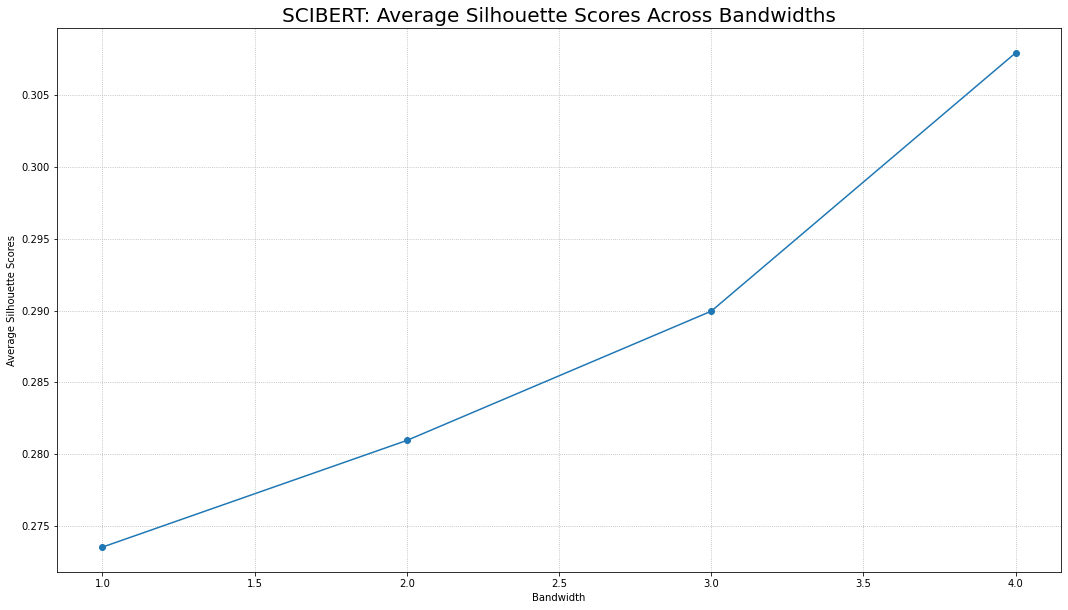

In [ ]:
###------ BIOBERT: Meanshift Method Plot of Silhouette Scores Across Bandwidths ------###
fig, ax = plt.subplots(1,1, figsize=(18, 10))
ax.plot(list(scibert_ms_sil_scores.keys()), list(scibert_ms_sil_scores.values()), marker='o')
ax.set_xlabel('Bandwidth')
ax.set_ylabel('Average Silhouette Scores')
ax.set_title('SCIBERT: Average Silhouette Scores Across Bandwidths', fontsize=20)
ax.grid(ls=':')

plt.show()


In [ ]:
for k, v in scibert_ms_model_dict.items():
  print(f'Number of Clusters for Bandwidth={k}: {len(pd.Series(v.labels_).unique())}')


Number of Clusters for Bandwidth=1: 2003
Number of Clusters for Bandwidth=2: 1984
Number of Clusters for Bandwidth=3: 1963
Number of Clusters for Bandwidth=4: 1903


Based on the above plot and statistics, the average Silhouette score rises as bandwidth increases. In addition, we do not select the number of clusters in Meanshift clustering method and let the model decide. The number of clusters resulted from Meanshift are very high (alsmost 2000 clusters) which means on average there are less than 2 sentences per clusters. This does not seem to be a good result and more of overfitting because we only have about 2400 instances in Asthma dataset. This is not a feasible model.

Next, we will try Meanshift Clustering on BioBert text embeddings and see if it performs better than SciBert.

### BIOBERT

In [ ]:
###------ SCIBERT: Meanshift Model Across Bandwidths ------###
biobert_ms_model_dict = {}
for i in range(1, 5, 1):
  ms_model_ = MeanShift(bandwidth=i, n_jobs=-1)
  ms_model_.fit(asthma_embeddings_biobert)
  biobert_ms_model_dict[i] = ms_model_

In [ ]:
###------ BIOBERT: Silhouette Scores Across n_clusters ------###

biobert_ms_sil_scores = {}
for k, v in biobert_ms_model_dict.items():
  sil_score_ = silhouette_score(asthma_embeddings_biobert, v.labels_, metric='cosine')
  biobert_ms_sil_scores[k] = sil_score_


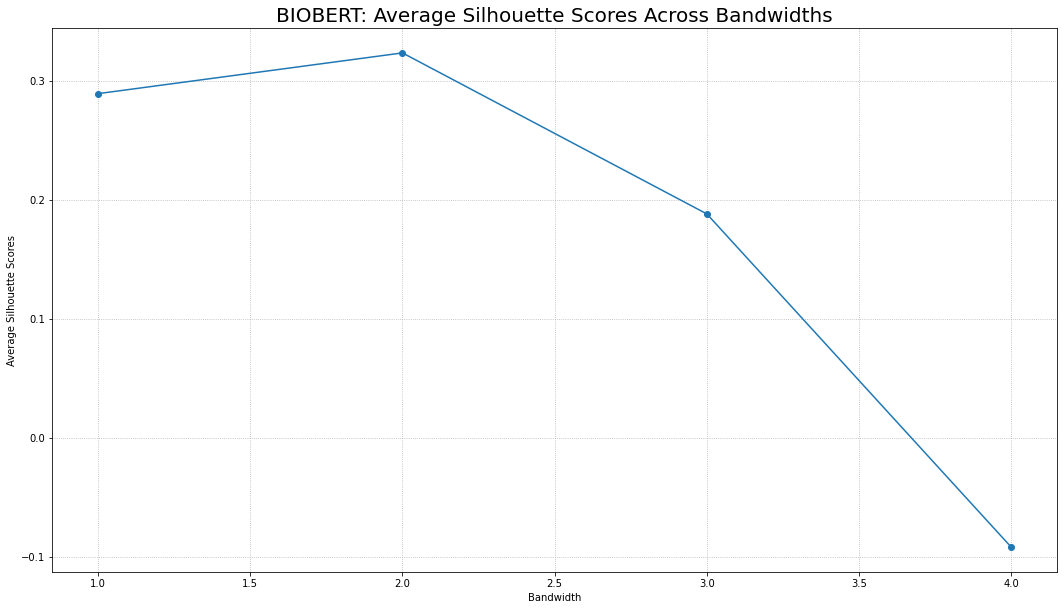

In [ ]:
###------ BIOBERT: Meanshift Method Plot of Silhouette Scores Across Bandwidth ------###
fig, ax = plt.subplots(1,1, figsize=(18, 10))
ax.plot(list(biobert_ms_sil_scores.keys()), list(biobert_ms_sil_scores.values()), marker='o')
ax.set_xlabel('Bandwidth')
ax.set_ylabel('Average Silhouette Scores')
ax.set_title('BIOBERT: Average Silhouette Scores Across Bandwidths', fontsize=20)
ax.grid(ls=':')

plt.show()


In [ ]:
for k, v in biobert_ms_model_dict.items():
  print(f'Number of Clusters for Bandwidth={k}: {len(pd.Series(v.labels_).unique())}')


Number of Clusters for Bandwidth=1: 1957
Number of Clusters for Bandwidth=2: 1699
Number of Clusters for Bandwidth=3: 848
Number of Clusters for Bandwidth=4: 220


The average Silhouette score is max at bandwidth = 2, but that comes at the expense of higher K (1700 clusters). Bandwidth = 4 results in smaller number of clusters (222 clusters) but the average Silhouette score is negative, indicating that data points, on average, are wrongly clustered.

Based on both model run on SciBert and BioBert, Meanshift Clustering is not a good method for our goal to cluster similar sentences.

## DBScan

In [ ]:
###------ Hyperparam Tuning: Epsilon & Min_samples ------###

### Create knee plot to select optimal epsilon and min_samples
def epsilon_plot(df, min_samples):
  nn_models = {}
  nn_dist_to_nth_nn = {}
  for i in min_samples:
    nearest_neighbor_ = NearestNeighbors(n_neighbors=i).fit(df)
    distances, indices = nearest_neighbor_.kneighbors(df)
    dist_to_nth_nearest_neighbor = distances[:,-1]
    nn_models[i] = nearest_neighbor_
    nn_dist_to_nth_nn[i] = dist_to_nth_nearest_neighbor

  fig, axes = plt.subplots(3,2, figsize=(15,15))
  for k, (j, ax) in enumerate(zip(min_samples, axes.flatten())):
    ax.plot(np.sort(nn_dist_to_nth_nn[j]))
    ax.set_xlabel("Distances")
    ax.set_ylabel('Epsilon')
    ax.set_title(f'Min_samples = {j}')
    ax.tick_params(right=True, labelright=True)
    ax.grid(ls=':')
    plt.tight_layout()
    

  return nn_models, nn_dist_to_nth_nn
  
    
    

### BIOBERT

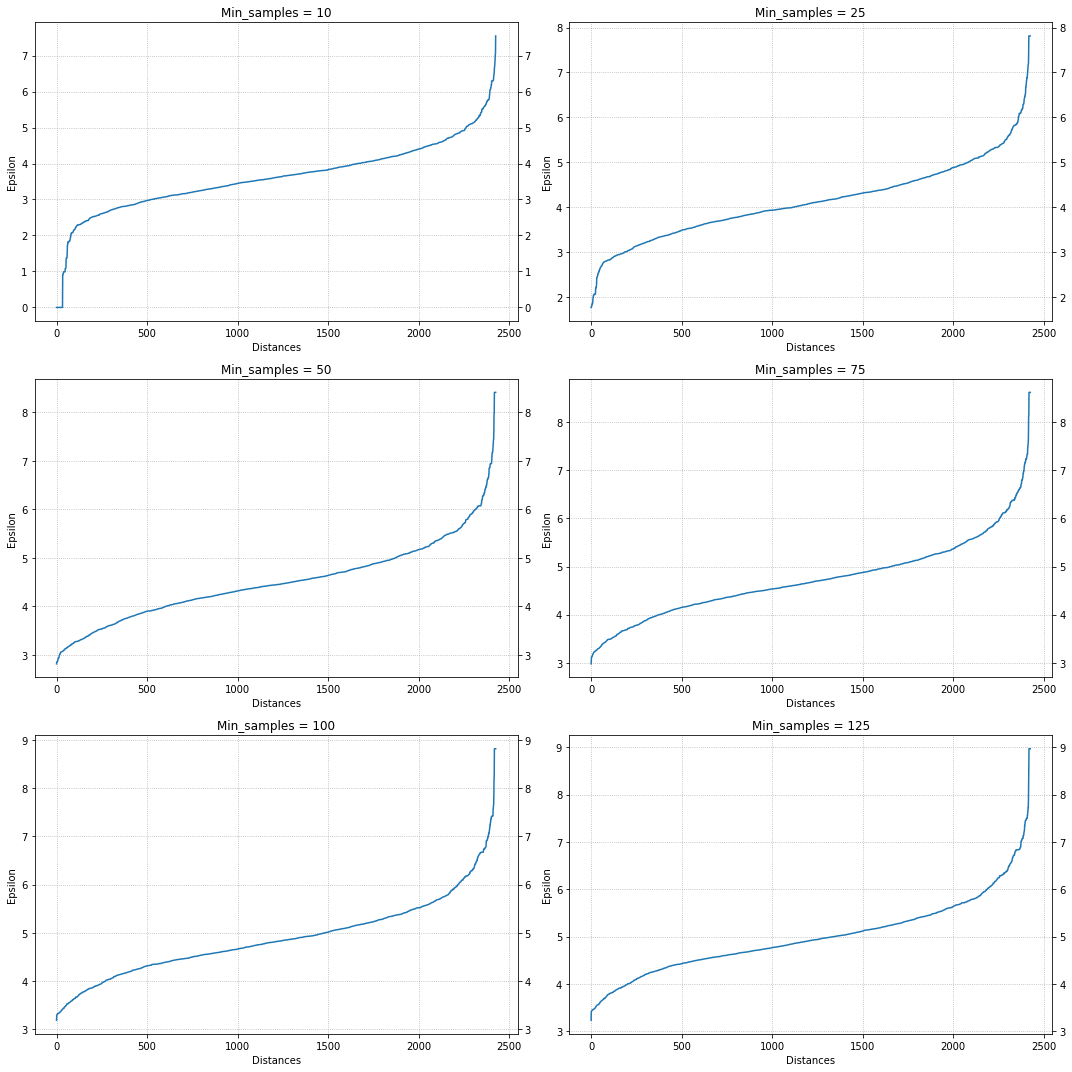

In [ ]:
###------ BIOBERT: Plot Epsilon & Min_sample ------###
biobert_tuning = epsilon_plot(asthma_embeddings_biobert, [10, 25, 50, 75, 100, 125])

According to the above knee plots, the cut-off epsilon is about 5 when min_samples = 10. As min_samples increase, epsilon also increases but the increase is diminishing, and the cut-off epsilon seems stable at 5.5 across various values of min_samples. Therefore, we select Epsilon=5.5.

In [ ]:
###------ DBScan Model - BioBert: Epsilon=5.5 ------###

### Compute Silhouette scores across min_samples with epsilon=5.5
biobert_dbscan_sil_scores = {}
for k, v in biobert_tuning[0].items():
  biobert_dbscan = DBSCAN(eps=5.5, min_samples=k).fit(asthma_embeddings_biobert)

  # Compute average Silhouette score - remove outliers labeled by -1 in DBScan result
  biobert_dbscan_sil_scores[k] = silhouette_score(asthma_embeddings_biobert, \
                                                  biobert_dbscan.labels_ != -1, metric='cosine')

  label_counts = {val: np.sum(biobert_dbscan.labels_ == val) for val in set(biobert_dbscan.labels_)}
  print(f"Min_samples = {k}:\n Label Counts: {label_counts} \n Average Silhouette Score: {biobert_dbscan_sil_scores[k]}\n")

  

Min_samples = 10:
 Label Counts: {0: 2403, -1: 24} 
 Average Silhouette Score: 0.46469980478286743

Min_samples = 25:
 Label Counts: {0: 2391, -1: 36} 
 Average Silhouette Score: 0.4294602572917938

Min_samples = 50:
 Label Counts: {0: 2382, -1: 45} 
 Average Silhouette Score: 0.42288124561309814

Min_samples = 75:
 Label Counts: {0: 2375, -1: 52} 
 Average Silhouette Score: 0.4220889210700989

Min_samples = 100:
 Label Counts: {0: 2369, -1: 58} 
 Average Silhouette Score: 0.41750797629356384

Min_samples = 125:
 Label Counts: {0: 2365, -1: 62} 
 Average Silhouette Score: 0.4139400124549866



Based on average Silhouette scores, max Silhouette score is when min_samples=10 (Silhouette score = 0.4646). Average Silhouette score decreases as min_samples increases but the decrease is very slow (diminishing decrease). Note that **Label = -1** in this case indicates outlier points, and not a cluster.

The result from DBScan is concerning because it clusters all data points to 1 cluster. This is not helpful for our purpose because our goal is to cluster sentences into different groups based on their similarity. One reason for this result is DBScan is based on density and this data set is highly densed that it is challenging to separate data points into different clusters, hence 1 big blob of all data points. DBScan is not a feasible method in our case.

### SCIBERT

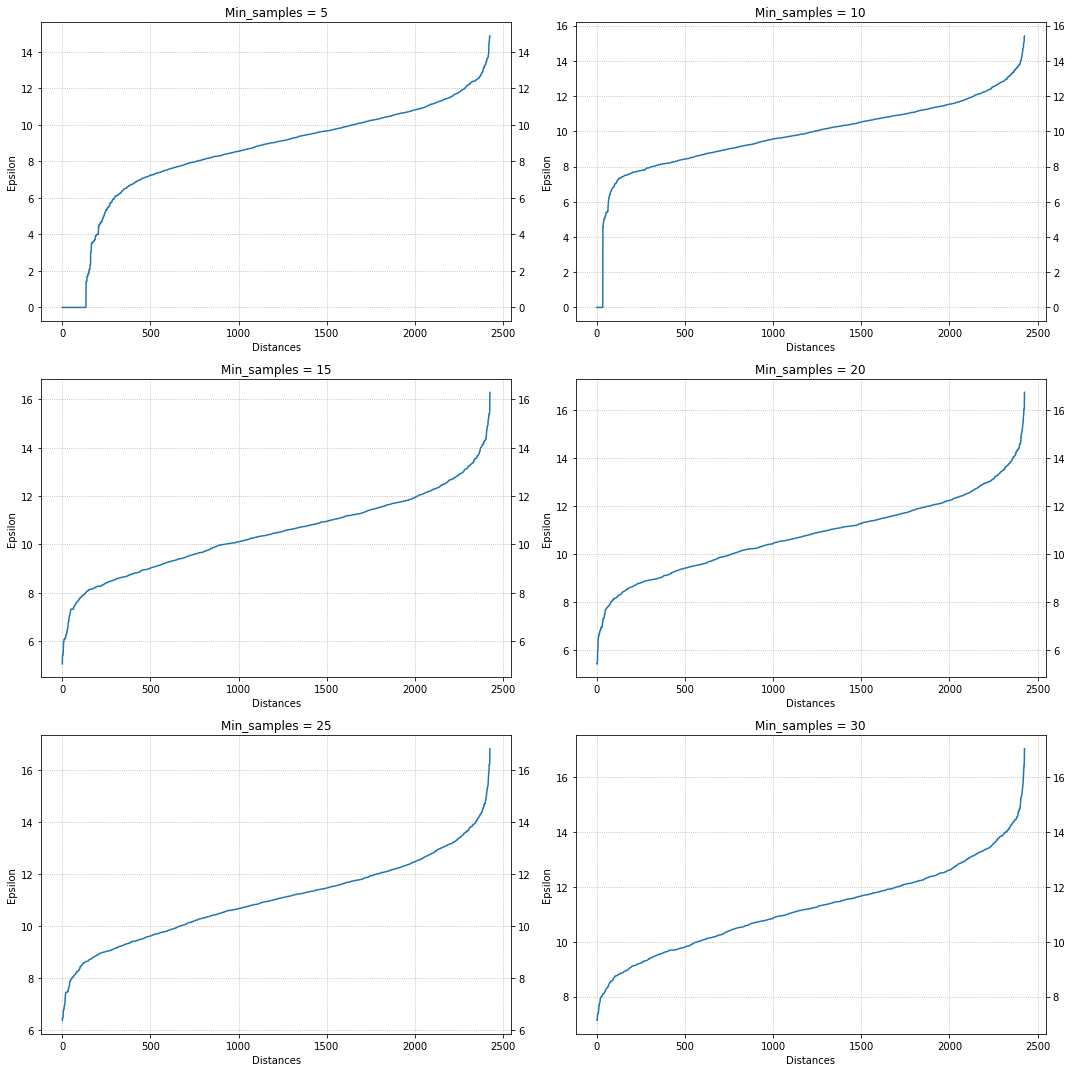

In [ ]:
###------ SCIBERT: Plot Epsilon & Min_sample ------###
scibert_tuning = epsilon_plot(asthma_embeddings_scibert, [5, 10, 15, 20, 25, 30])

The knee plots for SciBert model across suggests a cut-off at epsilon = 13.

In [ ]:
###------ DBScan Model - SciBert: Epsilon=13 ------###

### Compute Silhouette scores across min_samples with epsilon=13
scibert_dbscan_sil_scores = {}
for k, v in scibert_tuning[0].items():
  scibert_dbscan = DBSCAN(eps=13, min_samples=k).fit(asthma_embeddings_scibert)

  # Compute average Silhouette score - remove outliers labeled by -1 in DBScan result
  scibert_dbscan_sil_scores[k] = silhouette_score(asthma_embeddings_scibert, \
                                                  scibert_dbscan.labels_ != -1, metric='cosine')

  label_counts = {val: np.sum(scibert_dbscan.labels_ == val) for val in set(scibert_dbscan.labels_)}
  print(f"Min_samples = {k}:\n Label Counts: {label_counts} \n Average Silhouette Score: {scibert_dbscan_sil_scores[k]}\n")

  

Min_samples = 5:
 Label Counts: {0: 2408, -1: 19} 
 Average Silhouette Score: 0.2015572041273117

Min_samples = 10:
 Label Counts: {0: 2407, -1: 20} 
 Average Silhouette Score: 0.19913075864315033

Min_samples = 15:
 Label Counts: {0: 2398, -1: 29} 
 Average Silhouette Score: 0.232871875166893

Min_samples = 20:
 Label Counts: {0: 2392, -1: 35} 
 Average Silhouette Score: 0.2235296070575714

Min_samples = 25:
 Label Counts: {0: 2390, -1: 37} 
 Average Silhouette Score: 0.21883070468902588

Min_samples = 30:
 Label Counts: {0: 2390, -1: 37} 
 Average Silhouette Score: 0.21883070468902588



Similar to BioBert model, the result from SciBert DBScan model is not positive as it assigns all data to 1 cluster.


## Hierarchical Clustering

### SCIBERT

In [ ]:
###------ SCIBERT: Hierarchical Clustering Across n_clusters ------###

scibert_hc_dict = {}
for i in range(5, 500, 5):
    hc_ = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward', compute_distances=True)
    hc_fit_ = hc_.fit(asthma_embeddings_scibert)
    scibert_hc_dict[i] = hc_fit_
    


In [ ]:
###------ SCIBERT: Silhouette Scores Across n_clusters ------###

scibert_hc_sil_scores = {}
for k, v in scibert_hc_dict.items():
  sil_score_ = silhouette_score(asthma_embeddings_scibert, v.labels_, metric='cosine')
  scibert_hc_sil_scores[k] = sil_score_


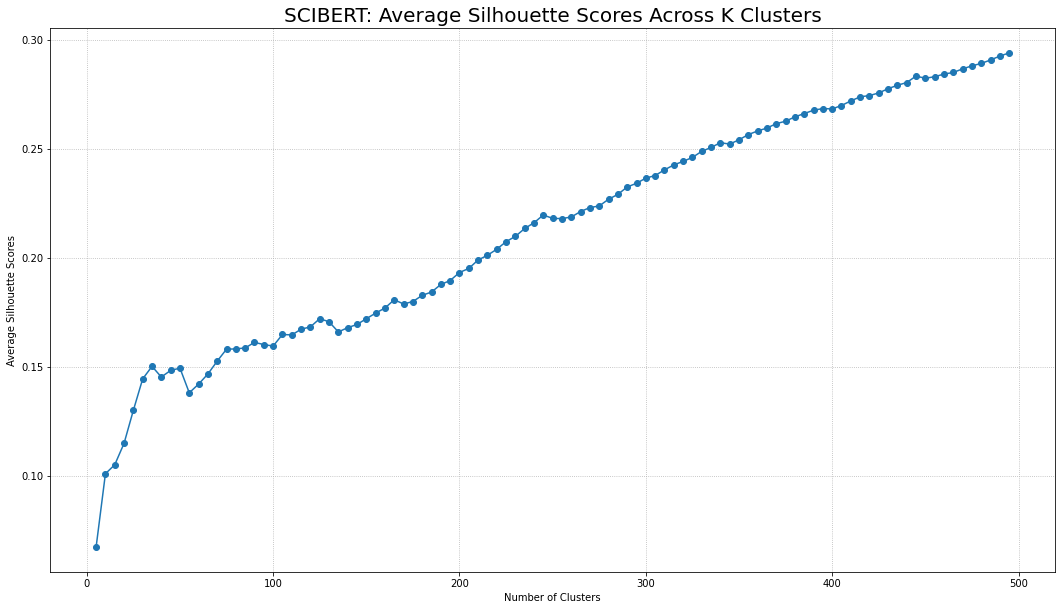

In [ ]:
###------ BIOBERT: Hierarchical Clustering Plot of Silhouette Scores Across n_clusters ------###
fig, ax = plt.subplots(1,1, figsize=(18, 10))
ax.plot(list(scibert_hc_sil_scores.keys()), list(scibert_hc_sil_scores.values()), marker='o')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Average Silhouette Scores')
ax.set_title('SCIBERT: Average Silhouette Scores Across K Clusters', fontsize=20)
ax.grid(ls=':')

plt.show()


The average Silhouette score plot across K for SciBert model sharply increases until K=35 then fluctuates and maintains the same score range between 0.15 and 0.20 up to K=200. It then keeps rising as K increases. In other words, the model performs well with more clusters (overfitting). Nevertheless, we select K=125 as our number of cluster for SciBert Hierarchical Clustering method because it averages out to a decent number of sentences per cluster and between K=100 and K=200 (which we think the model overfits at K=200), the difference in average Silhouette scores is not really significant (0.16 vs 0.19).


For n_clusters = 35 the average silhouette_score is : 0.15029775


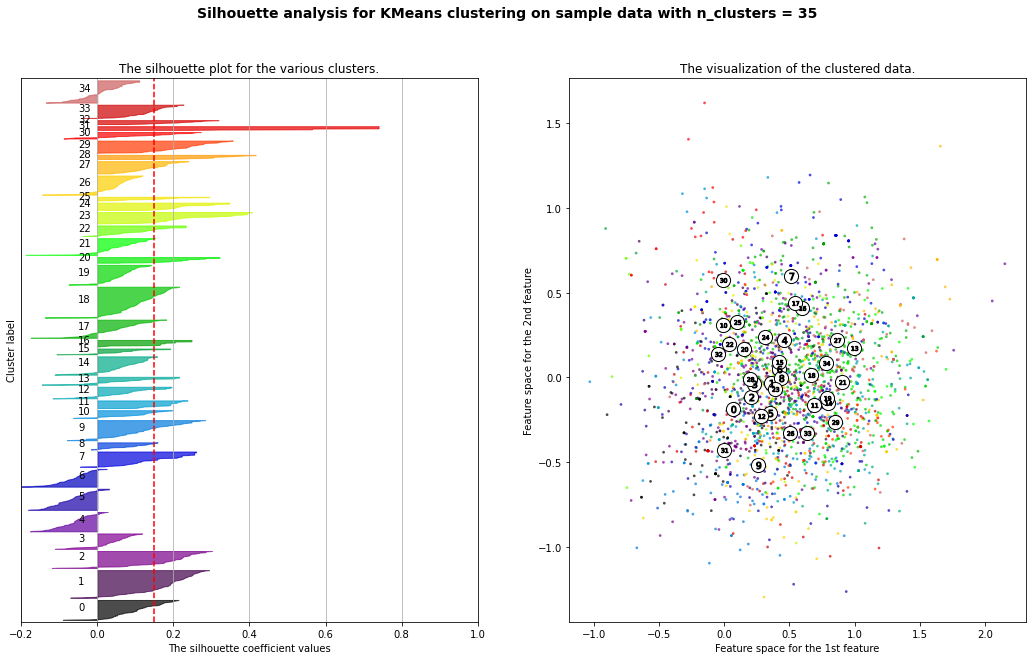


For n_clusters = 125 the average silhouette_score is : 0.17220515


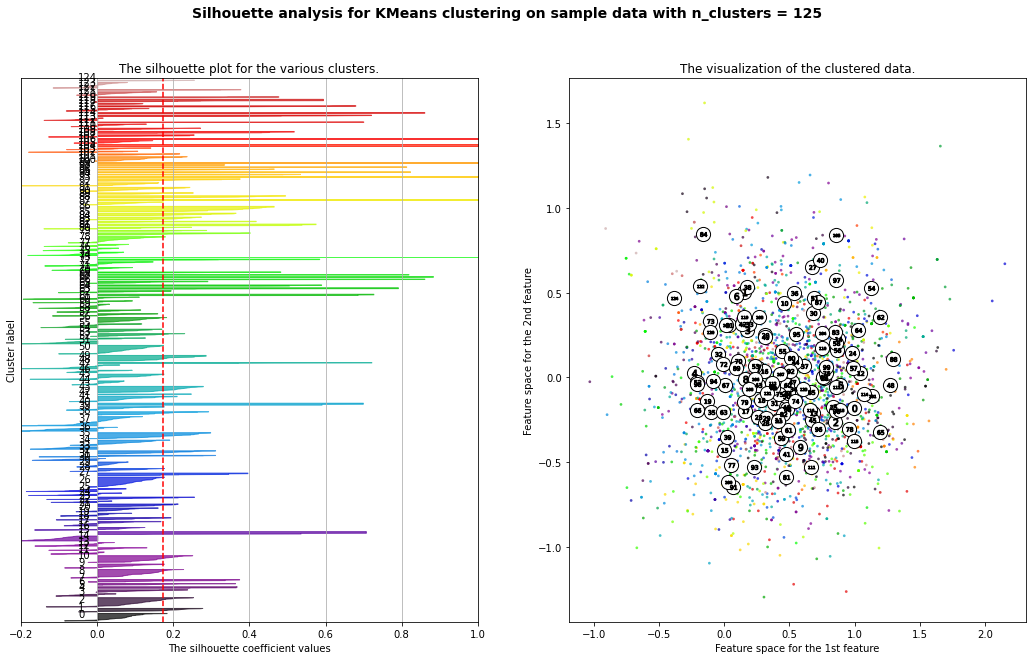

In [ ]:
###------ SCIBERT: Silhouette Plot K=35 ------###
custom_silhouette(asthma_embeddings_scibert, [35,125], 'Y')

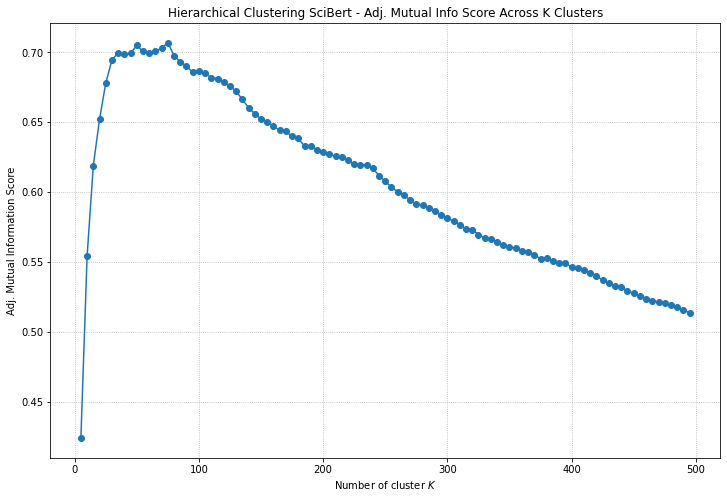

In [ ]:
###------ SCIBERT: Adjusted Mutual Information Score ------###
asthma_hc_scibert_ami_dict = {}
for k, v in scibert_hc_dict.items():
  asthma_hc_scibert_ami_dict[k] = adjusted_mutual_info_score(asthma_dat['Ground_Truth'], v.labels_)

###------ SCIBERT: Adj. Mutual Info Score Plot ------###

fig, ax = plt.subplots(1, 1, figsize=(12,8))

ax.plot(list(asthma_hc_scibert_ami_dict.keys()), list(asthma_hc_scibert_ami_dict.values()), marker='o')
ax.set_xlabel('Number of cluster $K$')
ax.set_ylabel('Adj. Mutual Information Score')
ax.set_title('Hierarchical Clustering SciBert - Adj. Mutual Info Score Across K Clusters')
ax.grid(ls=':')


Based on adjusted mutual infomation score, the highest AMI is at K=75. However, if we consider K range of less than 150 and observe the result from average Silhouette score plot, the model reaches higher average Silhouette score with higher Ks. We would go with the average Silhouette score in this case because the trade-off in AMI score is not much of a difference between K=75 and K=125.

In [ ]:
###------ SCIBERT: Adjusted Mutual Information Score ------###

hc_scibert_asthma_ami = adjusted_mutual_info_score(asthma_dat['Ground_Truth'], scibert_hc_dict[125].labels_)
print(f'Asthma SCIBERT - Hierarchical Clustering Model AMI Score: {round(100*hc_scibert_asthma_ami, 3)}%')


Asthma SCIBERT - Hierarchical Clustering Model AMI Score: 67.586%


### BIOBERT

In [ ]:
###------ BIOBERT: Hierarchical Clustering Across n_clusters ------###

biobert_hc_dict = {}
for i in range(5, 500, 5):
    hc_ = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward', compute_distances=True)
    hc_fit_ = hc_.fit(asthma_embeddings_biobert)
    biobert_hc_dict[i] = hc_fit_
    


In [ ]:
###------ BIOBERT: Silhouette Scores Across n_clusters ------###

biobert_hc_sil_scores = {}
for k, v in biobert_hc_dict.items():
  sil_score_ = silhouette_score(asthma_embeddings_biobert, v.labels_, metric='cosine')
  biobert_hc_sil_scores[k] = sil_score_


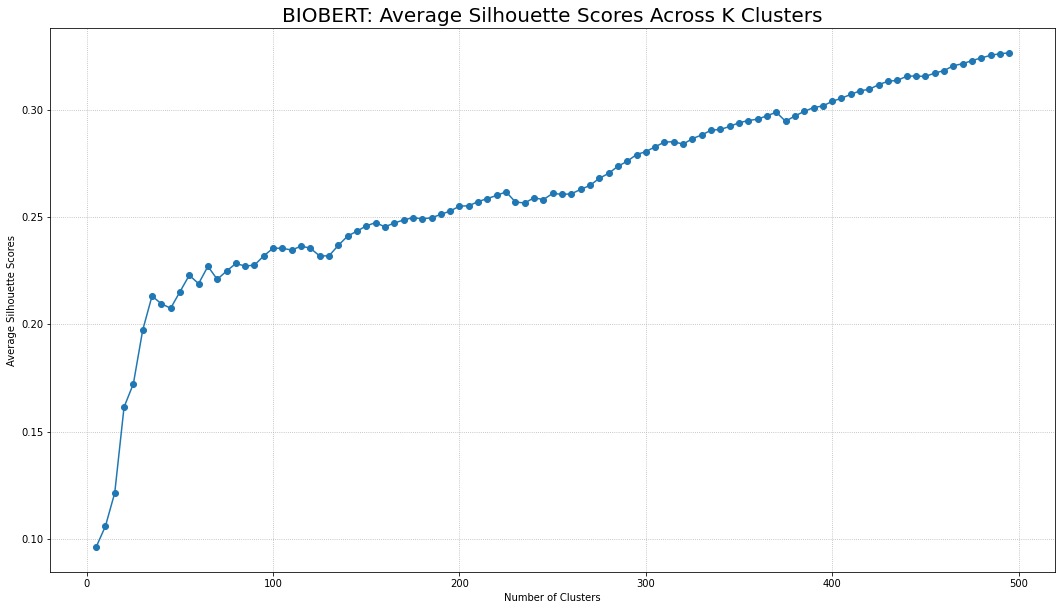

In [ ]:
###------ BIOBERT: Hierarchical Clustering Plot of Silhouette Scores Across n_clusters ------###
fig, ax = plt.subplots(1,1, figsize=(18, 10))
ax.plot(list(biobert_hc_sil_scores.keys()), list(biobert_hc_sil_scores.values()), marker='o')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Average Silhouette Scores')
ax.set_title('BIOBERT: Average Silhouette Scores Across K Clusters', fontsize=20)
ax.grid(ls=':')

plt.show()


The average Silhouette scores jump sharply between K=5 to K=35, then start to slowly increase as K increases. However, we risk overfitting the data if we pick a high K such as 500 (i.e., less than 5 sentences on average per cluster given our dataset). We see here K=100 appears to be a good pick because it reflects the increase in average Silhouette score compared with those of smaller Ks while it seems to maintain a decent number of sentences per cluster (roughly 24 sentences). Note that the average Silhouette score from BioBert model is higher than that of SciBert, suggesting that BioBert hierarchical model outperforms that of SciBert


For n_clusters = 100 the average silhouette_score is : 0.23562254


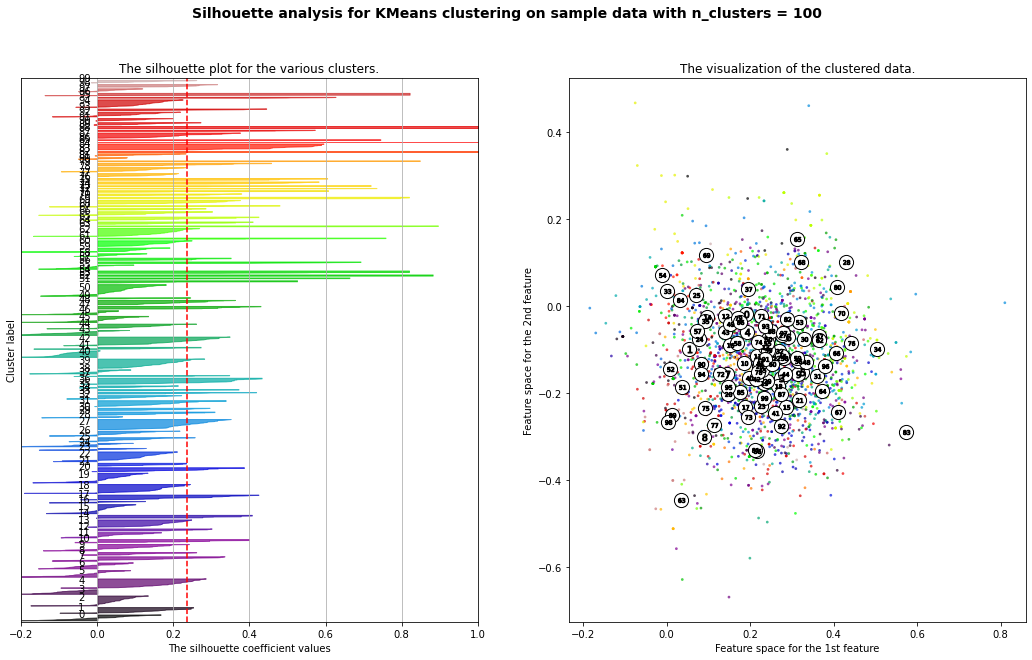

In [ ]:
###------ BIOBERT: Silhouette Plot K=100 ------###
custom_silhouette(asthma_embeddings_biobert, [100], 'Y')

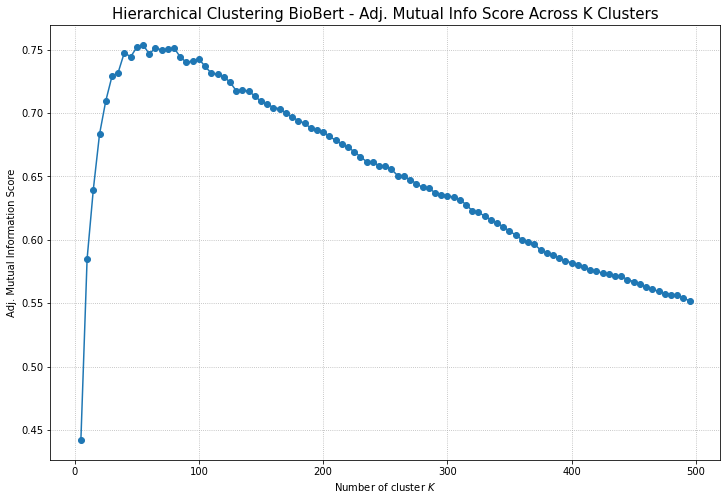

In [ ]:
###------ BIOBERT: Adjusted Mutual Information Score ------###
asthma_hc_biobert_ami_dict = {}
for k, v in biobert_hc_dict.items():
  asthma_hc_biobert_ami_dict[k] = adjusted_mutual_info_score(asthma_dat['Ground_Truth'], v.labels_)

###------ BIOBERT: Adj. Mutual Info Score Plot ------###

fig, ax = plt.subplots(1, 1, figsize=(12,8))

ax.plot(list(asthma_hc_biobert_ami_dict.keys()), list(asthma_hc_biobert_ami_dict.values()), marker='o')
ax.set_xlabel('Number of cluster $K$')
ax.set_ylabel('Adj. Mutual Information Score')
ax.set_title('Hierarchical Clustering BioBert - Adj. Mutual Info Score Across K Clusters', fontsize=15)
ax.grid(ls=':')


Based on average Silhouette score plot and AMI score plot, we select K=100.

In [ ]:
###------ BIOBERT: Adjusted Mutual Information Score ------###

hc_biobert_asthma_ami = adjusted_mutual_info_score(asthma_dat['Ground_Truth'], biobert_hc_dict[100].labels_)
print(f'Asthma BIOBERT - Hierarchical Clustering Model AMI Score: {round(100*hc_biobert_asthma_ami, 3)}%')


Asthma BIOBERT - Hierarchical Clustering Model AMI Score: 74.27%


In [ ]:
# Add hierarchicalcluster labels to df
asthma_clustering_df['biobert_hc_cluster'] = biobert_hc_dict[100].labels_

# Re-organize df
df_cols = ['criterion', 'embeddings', 'scibert_kmeans', 'biobert_kmeans', \
           'biobert_hc_cluster', 'ground_truth']

asthma_clustering_df = asthma_clustering_df.reindex(columns=df_cols)
asthma_clustering_df.head()



criterion  \
0  inability to carry out pulmonary function testing   
1  inability to carry out pulmonary function testing   
2  inability to perform lung function or other ma...   
3  patient unable to perform pulmonary function t...   
4    poor performance of pulmonary function testing    

                                          embeddings  scibert_kmeans  \
0  [-0.5822296, -0.50721264, 0.05819918, -0.18951...              83   
1  [-0.5822296, -0.50721264, 0.05819918, -0.18951...              83   
2  [-1.0294942, -0.025502924, -0.26240727, -0.377...              83   
3  [-0.004910692, -0.4367215, 0.22663999, -0.3332...              83   
4  [-0.62314427, -0.60829777, -0.20204248, 0.0822...              83   

   biobert_kmeans  biobert_hc_cluster  ground_truth  
0              86                  30           0.0  
1              86                  30           0.0  
2              86                  30           0.0  
3              86                  30           0.0  
4              86                  30           0.0

# Model Checking on Prostate Dataset

Out of all models above, we select K-Means SciBert, K-Means BioBert, Hierarchical Clustering SciBert, and Hierarchical Clustering BioBert to further run and test on Prostate dataset because the other models do not provide a good result and are not feasible for our clustering purpose.

In [ ]:
###------ Potential Models, Average Silhouette Score, Adj. Mutual Info Score ------##
asthma_model_scorecard = pd.DataFrame({
    'KMeans-SciBert': [asthma_km_skl_sih_scores_scibert[95], km_scibert_asthma_ami],
    'KMeans-BioBert': [asthma_km_skl_sih_scores_biobert[95], km_biobert_asthma_ami],
    'Hierarchial-SciBert': [scibert_hc_sil_scores[125], hc_scibert_asthma_ami],
    'Hierarchial-BioBert': [biobert_hc_sil_scores[100], hc_biobert_asthma_ami]
}, index=['Average Silhouette Score', 'Adj. Mutual Information'])

asthma_model_scorecard

KMeans-SciBert  KMeans-BioBert  Hierarchial-SciBert  \
Average Silhouette Score        0.173729        0.222049             0.172205   
Adj. Mutual Information         0.681783        0.711278             0.675864   

                          Hierarchial-BioBert  
Average Silhouette Score             0.235623  
Adj. Mutual Information              0.742696

We will run the these models on Prostate dataset to obtain clustering labels and check the result per method.

## KMeans - SCIBERT

In [ ]:
###------ PROSTATE: K-MEANS ON SCIBERT K=95 ------###

prostate_km_scibert = KMeans(n_clusters=95, init='k-means++', n_init=42, random_state=82).fit(prostate_embeddings_scibert)
prostate_km_scibert_sil_score = silhouette_score(prostate_embeddings_scibert, \
                                                 prostate_km_scibert.labels_, metric='cosine')
print(f'Prostate Kmeans on SciBert\n Average Silhouette Score: {prostate_km_scibert_sil_score}')



Prostate Kmeans on SciBert
 Average Silhouette Score: 0.10162190347909927


We will tune K-Means model on Prostate dataset to see if the model would pick a different K from our selected K=105 when we model Asthma dataset.

In [ ]:
                                  ###################################
                                  ### CLUSTERING BASED ON SCIBERT ###
                                  ###################################

###------ Looping through various K values ------###

### Dict of all models
prostate_km_skl_models_scibert = {}
for i in range(5,250,5):
    km_ = KMeans(n_clusters=i, init='k-means++', n_init=42, random_state=82).fit(prostate_embeddings_scibert)
    prostate_km_skl_models_scibert[i] = km_


### Dicts of all stats
prostate_km_skl_inertia_scibert = {}
prostate_km_skl_preds_scibert = {}
prostate_km_skl_sih_scores_scibert = {}
for k, v in prostate_km_skl_models_scibert.items():
    prostate_km_skl_inertia_scibert[k] = v.inertia_
    prostate_km_skl_preds_scibert[k] = v.predict(prostate_embeddings_scibert)
    prostate_km_skl_sih_scores_scibert[k] = silhouette_score(prostate_embeddings_scibert, v.labels_, metric='cosine')
                                                           
    
    

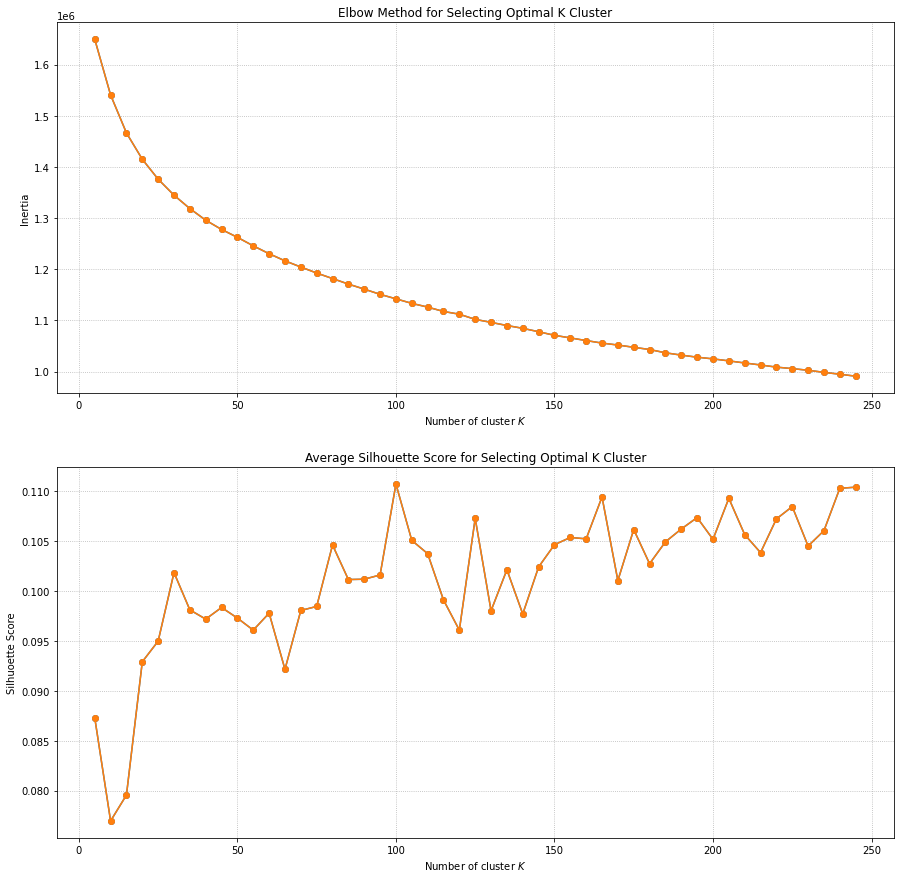

In [ ]:
###------ SCIBERT: Elbow Plot & Averageee Silhouette Score Plot ------###
elbow_silhouette_plot(range(5,250,5), \
                      list(prostate_km_skl_inertia_scibert.values()), \
                      list(prostate_km_skl_sih_scores_scibert.values()))

After retuning K-Means SciBert model over K clusters on Prostate dataset, the highest average Silhouette score is at K=100, which is not much of a difference from our result when we run K-Means on Asthma dataset, suggesting our model seem robust. We will however adjust our K for K-Means SciBert model to be 100 instead of 95.

In [ ]:
print(f'Prostate K-Means based on SciBert\n Average Silhouette Score - K=100: {prostate_km_skl_sih_scores_scibert[100]}')


Prostate K-Means based on SciBert
 Average Silhouette Score - K=100: 0.11073964089155197


## KMeans - BIOBERT

In [ ]:
###------ PROSTATE: K-MEANS ON BIOBERT K=95 ------###

prostate_km_biobert = KMeans(n_clusters=95, init='k-means++', n_init=42, random_state=82).fit(prostate_embeddings_biobert)
prostate_km_biobert_sil_score = silhouette_score(prostate_embeddings_biobert, \
                                                 prostate_km_biobert.labels_, metric='cosine')
print(f'Prostate Kmeans on BioBert\n Average Silhouette Score: {prostate_km_biobert_sil_score}')



Prostate Kmeans on BioBert
 Average Silhouette Score: 0.13556823134422302


In [ ]:
                                  ###################################
                                  ### CLUSTERING BASED ON BIOBERT ###
                                  ###################################

###------ Looping through various K values ------###

### Dict of all models
prostate_km_skl_models_biobert = {}
for i in range(5,250,5):
    km_ = KMeans(n_clusters=i, init='random', n_init=42, random_state=82).fit(prostate_embeddings_biobert)
    prostate_km_skl_models_biobert[i] = km_


### Dicts of all stats
prostate_km_skl_inertia_biobert = {}
prostate_km_skl_preds_biobert = {}
prostate_km_skl_sih_scores_biobert = {}
for k, v in prostate_km_skl_models_biobert.items():
    prostate_km_skl_inertia_biobert[k] = v.inertia_
    prostate_km_skl_preds_biobert[k] = v.predict(prostate_embeddings_biobert)
    prostate_km_skl_sih_scores_biobert[k] = silhouette_score(prostate_embeddings_biobert, v.labels_, metric='cosine')
                                                           

    
    

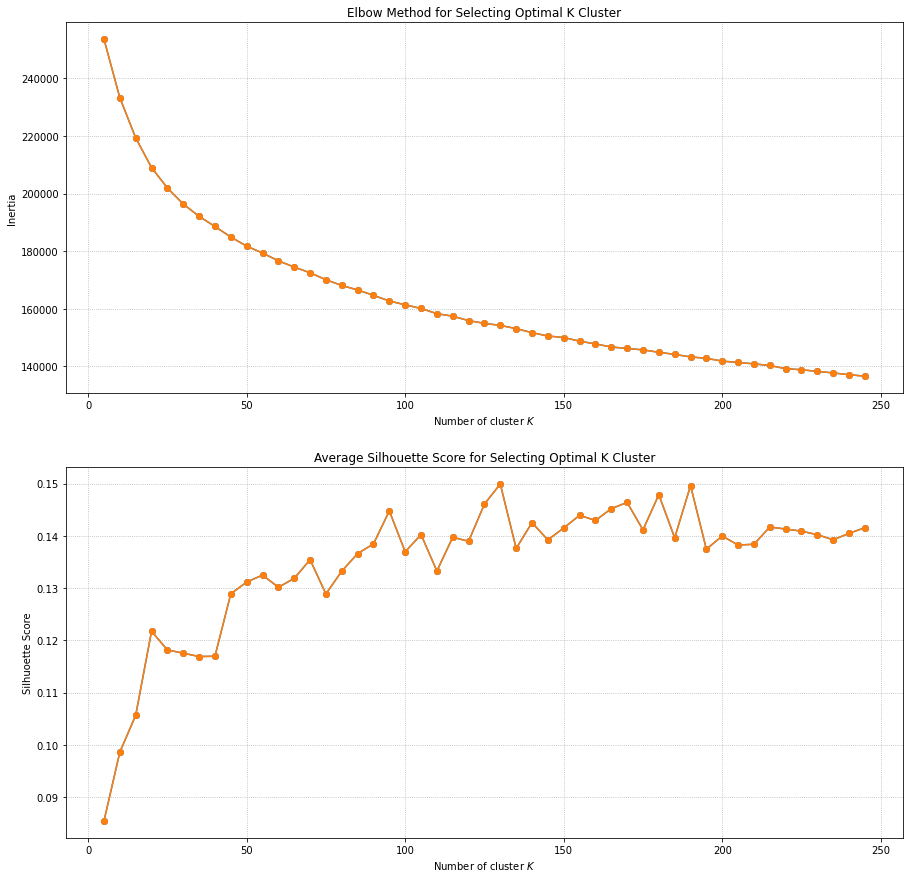

In [ ]:
###------ BIOBERT: Elbow Plot & Averageee Silhouette Score Plot ------###
elbow_silhouette_plot(range(5,250,5), \
                      list(prostate_km_skl_inertia_biobert.values()), \
                      list(prostate_km_skl_sih_scores_biobert.values()))

After re-tuning K-Means BioBert model for Prostate dataset, the highest average Silhouette score (about 0.15) is at K=130 based on the above plot. Therefore, we will adjust our K accordingly and use K=130 instead of 95 for this K-Means BioBert model.

In [ ]:
print(f'Prostate K-Means based on BioBert\n Average Silhouette Score - K=130: {prostate_km_skl_sih_scores_biobert[130]}')


Prostate K-Means based on BioBert
 Average Silhouette Score - K=130: 0.1499153971672058


## Meanshift - BIOBERT

In [ ]:
###------ PROSTATE: MEANSHIFT ON BIOBERT BANDWIDTH = 2 ------###
prostate_ms_biobert = MeanShift(bandwidth=2, n_jobs=-1).fit(prostate_embeddings_biobert)
prostate_ms_biobert_sil_score = silhouette_score(prostate_embeddings_biobert, \
                                                 prostate_ms_biobert.labels_, metric='cosine')
print(f'Prostate Meanshift on BioBert\n Average Silhouette Score: {prostate_ms_biobert_sil_score}')


Prostate Meanshift on BioBert
 Average Silhouette Score: 0.29967015981674194


In [ ]:
print(f'Total Number of Instances in Prostate Dataset: {len(prostate_dat)}')
print(f'Total Number of Clusters by Meanshift Model: {len(pd.Series(prostate_ms_biobert.labels_).unique())}')

Total Number of Instances in Prostate Dataset: 14314
Total Number of Clusters by Meanshift Model: 10186


Meanshift model, as mentioned earlier when we model Asthma dataset, does not seem to be a good pick because it results in so many clusters (more than 10k clusters). In other words, there are less than 2 sentences per cluster and some clusters have 1 sentence only. We once again see density-based method is not appropriate and feasible for our purpose.

## Hierarchical Clustering - SCIBERT

In [ ]:
###------ PROSTATE: HIERARCHICAL CLUSTERING ON SCIBERT K = 125 ------###

prostate_hc_scibert = AgglomerativeClustering(n_clusters=125, \
                                              affinity='euclidean', \
                                              linkage='ward', compute_distances=True).fit(prostate_embeddings_scibert)
prostate_hc_scibert_sil_score = silhouette_score(prostate_embeddings_scibert, \
                                                 prostate_hc_scibert.labels_, metric='cosine')
print(f'Prostate Hierarchical Clustering on SciBert\n Average Silhouette Score: {prostate_hc_scibert_sil_score}')




Prostate Hierarchical Clustering on SciBert
 Average Silhouette Score: 0.05206428840756416


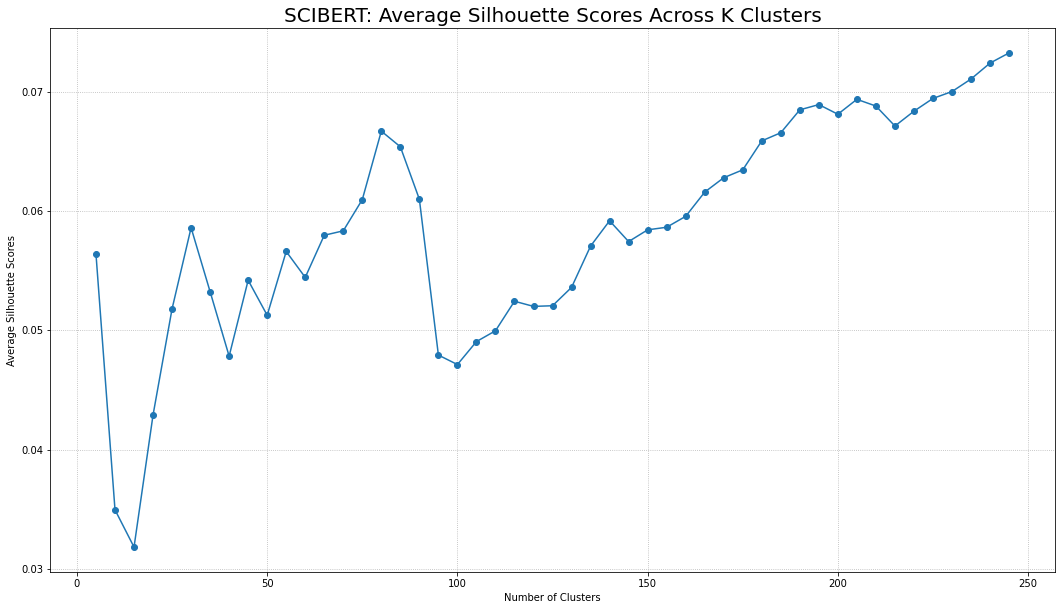

In [ ]:
###------ PROSTATE SCIBERT: Hierarchical Clustering Across n_clusters ------###

prostate_scibert_hc_dict = {}
for i in range(5, 250, 5):
    hc_ = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward', compute_distances=True)
    hc_fit_ = hc_.fit(prostate_embeddings_scibert)
    prostate_scibert_hc_dict[i] = hc_fit_
    

###------ SCIBERT: Silhouette Scores Across n_clusters ------###

prostate_scibert_hc_sil_scores = {}
for k, v in prostate_scibert_hc_dict.items():
  sil_score_ = silhouette_score(prostate_embeddings_scibert, v.labels_, metric='cosine')
  prostate_scibert_hc_sil_scores[k] = sil_score_


###------ SCIBERT: Hierarchical Clustering Plot of Silhouette Scores Across n_clusters ------###
fig, ax = plt.subplots(1,1, figsize=(18, 10))
ax.plot(list(prostate_scibert_hc_sil_scores.keys()), list(prostate_scibert_hc_sil_scores.values()), marker='o')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Average Silhouette Scores')
ax.set_title('SCIBERT: Average Silhouette Scores Across K Clusters', fontsize=20)
ax.grid(ls=':')

plt.show()



There is big drop in average Silhouette score from K=80 to K=100. Previously, we selected K=125 for Hierarchical Clustering model based on SciBert. We will adjust it according to the above result and select K=80 instead.

In [ ]:
###------ PROSTATE: HIERARCHICAL CLUSTERING ON SCIBERT K = 80 ------###

prostate_hc_scibert80 = AgglomerativeClustering(n_clusters=80, \
                                              affinity='euclidean', \
                                              linkage='ward', compute_distances=True).fit(prostate_embeddings_scibert)
prostate_hc_scibert_sil_score80 = silhouette_score(prostate_embeddings_scibert, \
                                                 prostate_hc_scibert.labels_, metric='cosine')
print(f'Prostate Hierarchical Clustering on SciBert\n Average Silhouette Score: {prostate_hc_scibert_sil_score80}')




Prostate Hierarchical Clustering on SciBert
 Average Silhouette Score: 0.05206428840756416


## Hierarchical Clustering - BIOBERT

In [ ]:
###------ PROSTATE: HIERARCHICAL CLUSTERING ON BIOBERT K = 100 ------###

prostate_hc_biobert = AgglomerativeClustering(n_clusters=100, \
                                              affinity='euclidean', \
                                              linkage='ward', compute_distances=True).fit(prostate_embeddings_biobert)
prostate_hc_biobert_sil_score = silhouette_score(prostate_embeddings_biobert, \
                                                 prostate_hc_biobert.labels_, metric='cosine')
print(f'Prostate Hierarchical Clustering on BioBert\n Average Silhouette Score: {prostate_hc_biobert_sil_score}')




Prostate Hierarchical Clustering on BioBert
 Average Silhouette Score: 0.10655036568641663


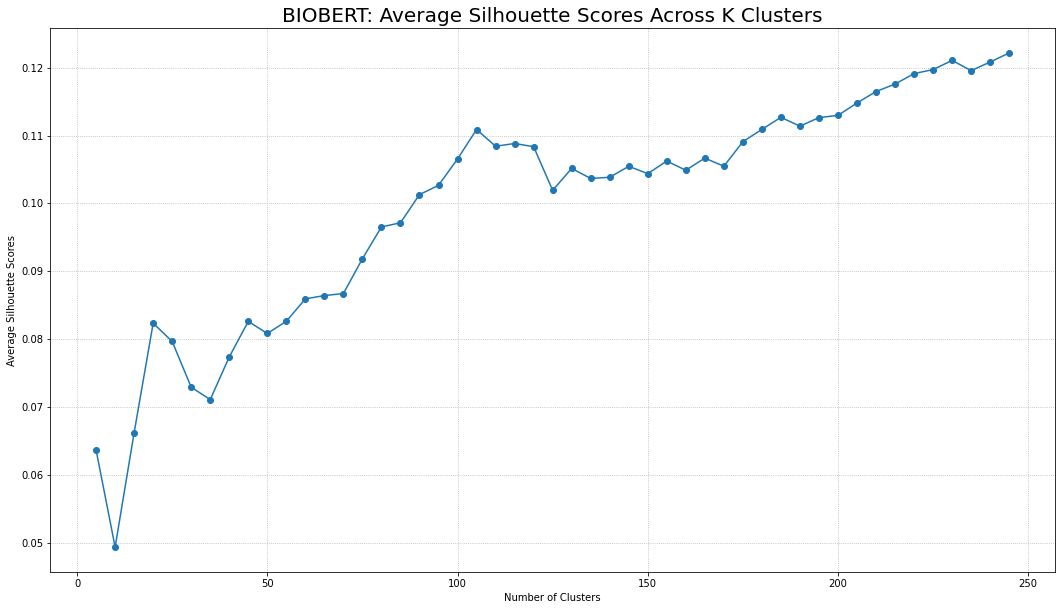

In [ ]:
###------ PROSTATE BIOBERT: Hierarchical Clustering Across n_clusters ------###

prostate_biobert_hc_dict = {}
for i in range(5, 250, 5):
    hc_ = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward', compute_distances=True)
    hc_fit_ = hc_.fit(prostate_embeddings_biobert)
    prostate_biobert_hc_dict[i] = hc_fit_
    

###------ BIOBERT: Silhouette Scores Across n_clusters ------###

prostate_biobert_hc_sil_scores = {}
for k, v in prostate_biobert_hc_dict.items():
  sil_score_ = silhouette_score(prostate_embeddings_biobert, v.labels_, metric='cosine')
  prostate_biobert_hc_sil_scores[k] = sil_score_


###------ BIOBERT: Hierarchical Clustering Plot of Silhouette Scores Across n_clusters ------###
fig, ax = plt.subplots(1,1, figsize=(18, 10))
ax.plot(list(prostate_biobert_hc_sil_scores.keys()), list(prostate_biobert_hc_sil_scores.values()), marker='o')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Average Silhouette Scores')
ax.set_title('BIOBERT: Average Silhouette Scores Across K Clusters', fontsize=20)
ax.grid(ls=':')

plt.show()



The updated average Silhouette score plot confirms that we can keep our previous choice of K=100 for Hierarchical Clustering based on BioBert embeddings. While K=105 is slight higher in terms of average Silhouette score, the difference is not significant.

## Prostate Label Predictions

In [ ]:
###------ PROSTATE: Cluster Label Dataframe ------###
prostate_clust_df = pd.DataFrame({
    'KMeans-SciBert': prostate_km_skl_models_scibert[100].labels_,
    'KMeans-BioBert': prostate_km_skl_models_biobert[130].labels_,
    'Hierarchical-SciBert': prostate_hc_scibert80.labels_,
    'Hierarchical-BioBert': prostate_hc_biobert.labels_

})
prostate_clust_df.head(10)

KMeans-SciBert  KMeans-BioBert  Hierarchical-SciBert  Hierarchical-BioBert
0              42              36                     0                    14
1              30              82                    28                    37
2              30              56                    28                    87
3              13              95                    36                    44
4              63              83                    15                    53
5              14              19                     2                    10
6              38              39                    27                    62
7              47               3                    58                    11
8              37              74                    58                    81
9              26              52                    62                    59

In [ ]:
###------ Write Prostate Cluster Prediction to CSV ------###
prostate_clust_df.to_csv('prostate_label_predictions.csv', index=False)

# Model Testing on Alzheimer Dataset

In [4]:
###------ Unzip Inclusion, Exclusion, Outcome Test Data ------###
!wget https://github.com/mlp2501/capstone_hes22/raw/main/cs82/HW5/Alzheimer.zip
!unzip Alzheimer.zip



--2022-11-23 19:00:17--  https://github.com/mlp2501/capstone_hes22/raw/main/cs82/HW5/Alzheimer.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlp2501/capstone_hes22/main/cs82/HW5/Alzheimer.zip [following]
--2022-11-23 19:00:17--  https://raw.githubusercontent.com/mlp2501/capstone_hes22/main/cs82/HW5/Alzheimer.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 656291 (641K) [application/zip]
Saving to: ‘Alzheimer.zip.1’

Alzheimer.zip.1     100%[===================>] 640.91K  --.-KB/s    in 0.05s   

2022-11-23 19:00:18 (12.1 MB/s) - ‘Alzheimer.zip.1’ saved [656291/656291]

Archive:  Alzh

In [6]:
###------ Read test files ------###
alzheimer_exclusion = pd.read_csv('Alzheimer_Ph23_exclusion.csv')
alzheimer_inclusion = pd.read_csv('Alzheimer_Ph23_inclusion.csv')
alzheimer_outcome = pd.read_table('Alzheimer_Ph23_outcome.txt')

print('='*80 + '\nExclusion\n' + '='*80)
display(alzheimer_exclusion.head(3))
print('='*80 + '\nInclusion\n' + '='*80)
display(alzheimer_inclusion.head(3))
print('='*80 + '\nOutcome\n' + '='*80)
display(alzheimer_outcome.head(3))



Exclusion


NCT#    phase          condition      sponsor start_date  \
0  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
1  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
2  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   

                       mesh_list                                  criterion  
0  Alzheimer Disease;Galantamine   Conditions that could confound diagnosis  
1  Alzheimer Disease;Galantamine                Neurodegenerative disorders  
2  Alzheimer Disease;Galantamine                      Acute cerebral trauma

Inclusion


NCT#    phase          condition      sponsor start_date  \
0  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
1  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
2  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   

                       mesh_list  \
0  Alzheimer Disease;Galantamine   
1  Alzheimer Disease;Galantamine   
2  Alzheimer Disease;Galantamine   

                                           criterion  
0                       Probable Alzheimer's disease  
1   Mini-Mental State Examination (MMSE) 10-22 an...  
2   Alzheimer's Disease Assessment Scale cognitiv...

Outcome


NCT#    phase            condition  \
0  NCT00010803  Phase 3  Alzheimer's Disease   
1  NCT00010803  Phase 3  Alzheimer's Disease   
2  NCT00010803  Phase 3  Alzheimer's Disease   

                                             sponsor start_date  \
0  National Center for Complementary and Integrat...     Oct-00   
1  National Center for Complementary and Integrat...     Oct-00   
2  National Center for Complementary and Integrat...     Oct-00   

           mesh_list                                          criterion  
0  Alzheimer Disease  Number of Participants With Incident Dementia;...  
1  Alzheimer Disease  Number of Participants With the Indicated Card...  
2  Alzheimer Disease  Progression of Cognitive Decline in Standardiz...

## Data Pre-Processing - Alzheimer Dataset

In [7]:
                                ###########################
                                ### ALZHEIMER EXCLUSION ###
                                ###########################

###------ Convert to lowercase & Remove punctuations  ------###
print('='*100 + '\nLOWERCASE & REMOVING PUNCTUATIONS' + '\nBefore:\n')
display(alzheimer_exclusion['criterion'].head(3))
alzheimer_exclusion['criterion'] = alzheimer_exclusion['criterion'].apply(lambda x: str(x).lower())
alzheimer_exclusion['criterion'] = alzheimer_exclusion['criterion'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
print(f'\n\nAfter:')
display(alzheimer_exclusion['criterion'].head(3))
print('\n' + '='*100)



###------ Remove StopWords using Spacy package ------###
# Loading English language model
nlp_spacy = spacy.load('en_core_web_sm')
all_stopwords = nlp_spacy.Defaults.stop_words
alzheimer_exclusion['no_sw_criterion'] = alzheimer_exclusion['criterion'].apply(lambda x: \
                                  ' '.join([token.lemma_ for token in list(nlp_spacy(x)) if (token.is_stop==False)]))


# Print criterion example
print('REMOVING STOPWORDS\n')
display(alzheimer_exclusion['no_sw_criterion'].iloc[:5])


LOWERCASE & REMOVING PUNCTUATIONS
Before:



0     Conditions that could confound diagnosis
1                  Neurodegenerative disorders
2                        Acute cerebral trauma
Name: criterion, dtype: object



After:


0     conditions that could confound diagnosis
1                  neurodegenerative disorders
2                        acute cerebral trauma
Name: criterion, dtype: object


REMOVING STOPWORDS



0      condition confound diagnosis
1        neurodegenerative disorder
2             acute cerebral trauma
3               psychiatric disease
4                infarct ctmri scan
Name: no_sw_criterion, dtype: object

In [8]:
                                ###########################
                                ### ALZHEIMER INCLUSION ###
                                ###########################

###------ Convert to lowercase & Remove punctuations  ------###
print('='*100 + '\nLOWERCASE & REMOVING PUNCTUATIONS' + '\nBefore:\n')
display(alzheimer_inclusion['criterion'].head(3))
alzheimer_inclusion['criterion'] = alzheimer_inclusion['criterion'].apply(lambda x: str(x).lower())
alzheimer_inclusion['criterion'] = alzheimer_inclusion['criterion'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
print(f'\n\nAfter:')
display(alzheimer_inclusion['criterion'].head(3))
print('\n' + '='*100)



###------ Remove StopWords using Spacy package ------###
# Loading English language model
nlp_spacy = spacy.load('en_core_web_sm')
all_stopwords = nlp_spacy.Defaults.stop_words
alzheimer_inclusion['no_sw_criterion'] = alzheimer_inclusion['criterion'].apply(lambda x: \
                                  ' '.join([token.lemma_ for token in list(nlp_spacy(x)) if (token.is_stop==False)]))


# Print criterion example
print('REMOVING STOPWORDS\n')
display(alzheimer_inclusion['no_sw_criterion'].iloc[:5])


LOWERCASE & REMOVING PUNCTUATIONS
Before:



0                         Probable Alzheimer's disease
1     Mini-Mental State Examination (MMSE) 10-22 an...
2     Alzheimer's Disease Assessment Scale cognitiv...
Name: criterion, dtype: object



After:


0                          probable alzheimers disease
1     minimental state examination mmse 1022 and ad...
2     alzheimers disease assessment scale cognitive...
Name: criterion, dtype: object


REMOVING STOPWORDS



0                           probable alzheimer disease
1      minimental state examination mmse 1022 adas ...
2      alzheimers disease assessment scale cognitiv...
3                    opportunity activity daily living
4                                            caregiver
Name: no_sw_criterion, dtype: object

In [9]:
                                ###########################
                                ### ALZHEIMER OUTCOME ###
                                ###########################

###------ Convert to lowercase & Remove punctuations  ------###
print('='*100 + '\nLOWERCASE & REMOVING PUNCTUATIONS' + '\nBefore:\n')
display(alzheimer_outcome['criterion'].head(3))
alzheimer_outcome['criterion'] = alzheimer_outcome['criterion'].apply(lambda x: str(x).lower())
alzheimer_outcome['criterion'] = alzheimer_outcome['criterion'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
print(f'\n\nAfter:')
display(alzheimer_outcome['criterion'].head(3))
print('\n' + '='*100)



###------ Remove StopWords using Spacy package ------###
# Loading English language model
nlp_spacy = spacy.load('en_core_web_sm')
all_stopwords = nlp_spacy.Defaults.stop_words
alzheimer_outcome['no_sw_criterion'] = alzheimer_outcome['criterion'].apply(lambda x: \
                                  ' '.join([token.lemma_ for token in list(nlp_spacy(x)) if (token.is_stop==False)]))


# Print criterion example
print('REMOVING STOPWORDS\n')
display(alzheimer_outcome['no_sw_criterion'].iloc[:5])


LOWERCASE & REMOVING PUNCTUATIONS
Before:



0    Number of Participants With Incident Dementia;...
1    Number of Participants With the Indicated Card...
2    Progression of Cognitive Decline in Standardiz...
Name: criterion, dtype: object



After:


0    number of participants with incident dementiaa...
1    number of participants with the indicated card...
2    progression of cognitive decline in standardiz...
Name: criterion, dtype: object


REMOVING STOPWORDS



0    number participant incident dementiaall cause ...
1    number participant indicate cardiovascular dis...
2    progression cognitive decline standardized zsc...
3    brief praxis test measure cognitive function e...
4    fuld object memory test modify new dot test or...
Name: no_sw_criterion, dtype: object

In [22]:
                        ###########################################
                        ### ALZHEIMER EXCLUSION: TEXT EMBEDDING ###
                        ###########################################

###------ SCIBERT ------###
excl_scibert_transformer_model = SentenceTransformer(model_scibert)

###------ BIOBERT ------###
excl_biobert_transformer_model = SentenceTransformer(model_biobert)

###------ Embedding all sentences ------###
excl_embeddings_scibert = excl_scibert_transformer_model.encode(alzheimer_exclusion['no_sw_criterion'], convert_to_tensor=True)
excl_embeddings_biobert = excl_scibert_transformer_model.encode(alzheimer_exclusion['no_sw_criterion'], convert_to_tensor=True)


Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /root/.cache/torch/sentence

In [23]:
                        ###########################################
                        ### ALZHEIMER INCLUSION: TEXT EMBEDDING ###
                        ###########################################

###------ SCIBERT ------###
incl_scibert_transformer_model = SentenceTransformer(model_scibert)

###------ BIOBERT ------###
incl_biobert_transformer_model = SentenceTransformer(model_biobert)

###------ Embedding all sentences ------###
incl_embeddings_scibert = incl_scibert_transformer_model.encode(alzheimer_inclusion['no_sw_criterion'], convert_to_tensor=True)
incl_embeddings_biobert = incl_scibert_transformer_model.encode(alzheimer_inclusion['no_sw_criterion'], convert_to_tensor=True)


Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /root/.cache/torch/sentence

In [ ]:
                        ###########################################
                        ### ALZHEIMER OUTCOME: TEXT EMBEDDING ###
                        ###########################################

###------ SCIBERT ------###
outcome_scibert_transformer_model = SentenceTransformer(model_scibert)

###------ BIOBERT ------###
outcome_biobert_transformer_model = SentenceTransformer(model_biobert)

###------ Embedding all sentences ------###
outcome_embeddings_scibert = outcome_scibert_transformer_model.encode(alzheimer_outcome['no_sw_criterion'], convert_to_tensor=True)
outcome_embeddings_biobert = outcome_scibert_transformer_model.encode(alzheimer_outcome['no_sw_criterion'], convert_to_tensor=True)


Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /root/.cache/torch/sentence

## Cluster Prediction

### Exclusion

In [ ]:
###------ EXCLUSION: Cluster Predictions ------###
km_scibert_exclusion_label_preds = prostate_km_skl_models_scibert[100].predict(excl_embeddings_scibert)
km_biobert_exclusion_label_preds = prostate_km_skl_models_biobert[130].predict(excl_embeddings_biobert)
hc_scibert_exclusion_label_preds = prostate_scibert_hc_dict[80].fit_predict(excl_embeddings_scibert)
hc_biobert_exclusion_label_preds = prostate_biobert_hc_dict[100].fit_predict(excl_embeddings_biobert)



In [25]:
###------ EXCLUSION: Cluster Label Dataframe ------###
excl_clust_df = pd.DataFrame({
    'KMeans100-SciBert': km_scibert_exclusion_label_preds,
    'KMeans130-BioBert': km_biobert_exclusion_label_preds,
    'HierClust80-SciBert': hc_scibert_exclusion_label_preds,
    'HierClust100-BioBert': hc_biobert_exclusion_label_preds

})
print('='*100 + '\nEXCLUSION CLUSTER PREDICTION\n' + '='*100)
excl_clust_df.head()


EXCLUSION CLUSTER PREDICTION


KMeans100-SciBert  KMeans130-BioBert  HierClust80-SciBert  \
0                 73                 22                   16   
1                 73                 22                   29   
2                 38                 71                    6   
3                 73                 22                   55   
4                 32                 71                   56   

   HierClust100-BioBert  
0                    93  
1                    29  
2                    16  
3                    97  
4                    13

In [26]:
###------ Write to csv files ------###
excl_clust_df.to_csv('exclusion.csv', index=False)


### Inclusion

In [ ]:
###------ INCLUSION: Cluster Predictions ------###
km_scibert_inclusion_label_preds = prostate_km_skl_models_scibert[100].predict(incl_embeddings_scibert)
km_biobert_inclusion_label_preds = prostate_km_skl_models_biobert[130].predict(incl_embeddings_biobert)
hc_scibert_inclusion_label_preds = prostate_scibert_hc_dict[80].fit_predict(incl_embeddings_scibert)
hc_biobert_inclusion_label_preds = prostate_biobert_hc_dict[100].fit_predict(incl_embeddings_biobert)

In [28]:

###------ INCLUSION: Cluster Label Dataframe ------###
incl_clust_df = pd.DataFrame({
    'KMeans100-SciBert': km_scibert_inclusion_label_preds,
    'KMeans130-BioBert': km_biobert_inclusion_label_preds,
    'HierClust80-SciBert': hc_scibert_inclusion_label_preds,
    'HierClust100-BioBert': hc_biobert_inclusion_label_preds

})
print('='*100 + '\nINCLUSION CLUSTER PREDICTION\n' + '='*100)
incl_clust_df.head()


INCLUSION CLUSTER PREDICTION


KMeans100-SciBert  KMeans130-BioBert  HierClust80-SciBert  \
0                  1                 22                   42   
1                 70                 22                    4   
2                 59                 71                   32   
3                 78                 52                   70   
4                 50                 22                   14   

   HierClust100-BioBert  
0                    20  
1                    45  
2                     7  
3                    70  
4                    15

In [29]:
###------ Write to csv files ------###
incl_clust_df.to_csv('inclusion.csv', index=False)


### Outcome

In [ ]:
###------ OUTCOME: Cluster Predictions ------###
km_scibert_outcome_label_preds = prostate_km_skl_models_scibert[100].predict(outcome_embeddings_scibert)
km_biobert_outcome_label_preds = prostate_km_skl_models_biobert[130].predict(outcome_embeddings_biobert)
hc_scibert_outcome_label_preds = prostate_scibert_hc_dict[80].fit_predict(outcome_embeddings_scibert)
hc_biobert_outcome_label_preds = prostate_biobert_hc_dict[100].fit_predict(outcome_embeddings_biobert)


###------ OUTCOME: Cluster Label Dataframe ------###
outcome_clust_df = pd.DataFrame({
    'KMeans100-SciBert': km_scibert_outcome_label_preds,
    'KMeans130-BioBert': km_biobert_outcome_label_preds,
    'HierClust80-SciBert': hc_scibert_outcome_label_preds,
    'HierClust100-BioBert': hc_biobert_outcome_label_preds

})
print('='*100 + '\nOUTCOME CLUSTER PREDICTION\n' + '='*100)
outcome_clust_df.head()


OUTCOME CLUSTER PREDICTION


KMeans100-SciBert  KMeans130-BioBert  HierClust80-SciBert  \
0                 19                 78                   46   
1                 27                 78                   60   
2                  8                108                   16   
3                 70                 78                   38   
4                 70                 78                   12   

   HierClust100-BioBert  
0                    46  
1                    60  
2                     7  
3                     8  
4                    17

In [ ]:
###------ Write to csv files ------###
outcome_clust_df.to_csv('outcome.csv', index=False)
